In [1]:
import numpy as np
import numpy.linalg as la
from scipy import linalg
from scipy import spatial
import matplotlib.pyplot as plt
from math import *
import time

$$\phi(\mathbf{x};\mathbf{a}) = \mathbf{a}\cdot\mathbf{x} + \frac{1}{2}\mathbf{x}^TA\mathbf{x} - a_5e^{-\frac{1}{2}a_6^2|x+\mathbf{a}_m|^2}$$
where $$\mathbf{x} = (x_0,x_1),\mathbf{a} = (a_0,a_1), A = 
                                \begin{pmatrix}
                                    1+a_2 & a_3\\
                                    a_3 & 1+a_4
                                \end{pmatrix}, \mathbf{a}_m = (a_7,a_8)$$

$$g(\mathbf{z};\mathbf{b}) = b_0 + \mathbf{b}\cdot\mathbf{z} + \frac{1}{2}\mathbf{z}^TB\mathbf{z} + b_6e^{-\frac{1}{2}b_7^2|\mathbf{z}+\mathbf{b}'|^2} + b_{10}e^{-\frac{1}{2}b_{11}^2|\mathbf{z}+\mathbf{b}''|^2}$$
where
$$\mathbf{b} = (b_1,b_2), B=\begin{pmatrix}
                                b_3 & b_4\\
                                b_4 & b_5
                            \end{pmatrix}, \mathbf{b}' = (b_8,b_9), \mathbf{b}'' = (b_{12},b_{13})$$

$$
T(\mathbf{x};\mathbf{a}) = \nabla\phi(\mathbf{x};\mathbf{a})=  \begin{pmatrix} a_0 + (1+a_2) x_0 + a_3 x_1 + a_5 a_6^2 (x_0+a_7) e^{-0.5 a_6^2((x_0+a_7)^2 + (x_1+a_8)^2)} \\ a_1 + (1+a_4) x_1 + a_3 x_0 + a_5 a_6^2 (x_1+a_8) e^{-0.5 a_6^2((x_0+a_7)^2 + (x_1+a_8)^2)} \end{pmatrix}\\
 = T_0(x) + T_1(x)
$$
and  
$$
g(\mathbf{z};\mathbf{b}) =b_0 + b_1 z_0 + b_2 z_1 + 0.5 b_3 z_0^2 + b_4 z_0z_1 + 0.5 b_5 z_1^2 + b_6 \exp \left( -\frac{1}{2}b_7^2((z_0+b_8)^2 + (z_1+b_9)^2) \right) + b_{10} \exp \left( -\frac{1}{2}b_{11}^2((z_0+b_{12})^2 + (z_1+b_{13})^2) \right) \\
 = g_0(z) + g_1(z) + g_2(z)
$$

Penalization:
$a_6,b_7, b_{11}$ penalized as $e^{\epsilon^2 \sigma^2 } - 1/(D^2 \sigma^2)$

$a_7,a_9,b_8,b_9,b_{12},b_{13}$ penalized as $m^2/(10 D^2)$
where $D$ is an estimate of the size of the support of the data (e.g. std), $\epsilon = \max_i \min_j |x_i-y_j|$

In [116]:
d = 2
Nx = 400
Ny = 600

# #Guassians
# mx = np.array([0,0])
# sx = np.array([[1.0,0.0],[0.0,1.0]])
# my = np.array([5.9,5.9])
# sy = np.array([[2.4,0.0],[0.0,2.4]])
# x = np.random.multivariate_normal(mx,sx,Nx)
# y = np.random.multivariate_normal(my,sy,Ny)

# #Gaussian to 2 mixed Gaussian
# mx = np.array([0,0])
# sx = np.array([[4.0,0.0],[0.0,4.0]])
# my1 = np.array([4,0])
# sy1 = np.array([[1.0,0.0],[0.0,1.0]])
# my2 = np.array([-4,0])
# sy2 = np.array([[1.0,0.0],[0.0,1.0]])
# x = np.random.multivariate_normal(mx,sx,Nx)
# y_one = np.random.multivariate_normal(my1,sy1,Ny)
# y_two = np.random.multivariate_normal(my2,sy2,Ny)
# y = np.concatenate([y_one,y_two],axis=0)

#Gaussian to annulus
mx = np.array([-2,0])
sx = np.array([[1.0,0.0],[0.0,1.0]])
x = np.random.multivariate_normal(mx,sx,Nx)
r = 2*np.sqrt(np.random.uniform(0.8,1,Ny))
theta = 2*pi*np.random.uniform(0,1,Ny)
y = np.zeros((Ny,2))
y[:,0]=r*np.cos(theta)
y[:,1]=r*np.sin(theta)

# #Square lattices
# x = np.zeros((32**2,2))
# for i in range(32**2):
#     x[i][0] = (i//32)/32
#     x[i][1] = (i%32)/32

# y = x + 0.02
    
# # y = np.zeros((33*34,2))
# # for i in range(33*34):
# #     y[i][0] = (i//34)/33
# #     y[i][1] = (i%34)/34
# # y += 0.01

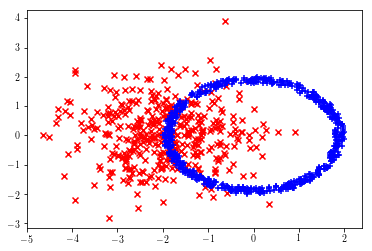

In [117]:
plt.scatter(x[:,0],x[:,1], color='red',marker = 'x');
plt.scatter(y[:,0],y[:,1], color='blue', marker = '+');

# Precomputation: Lagrangian and GH
1.$\textbf{Lagragian}$: $$ L(\mathbf{a},\mathbf{b}) = \frac{1}{n}\sum_{i=1}^ng(\nabla_{\overrightarrow{x}}\phi(\overrightarrow{\mathbf{x}_i};\mathbf{a});\mathbf{b})-\frac{1}{m}\sum_{j=1}^me^{g(\overrightarrow{\mathbf{y}_j};\mathbf{b})}$$
2.$\textbf{Gradient}$:
$$ \nabla L(\mathbf{a},\mathbf{b}) = (\nabla_{\mathbf{a}}L,\nabla_{\mathbf{b}}L)$$
3.$\textbf{Hessian}$: 
$$H = \begin{pmatrix}\nabla_{\mathbf{a}}\nabla_{\mathbf{a}}L & \nabla_{\mathbf{a}}\nabla_{\mathbf{b}}L\\
\nabla_{\mathbf{a}}\nabla_{\mathbf{b}}L & \nabla_{\mathbf{b}}\nabla_{\mathbf{b}}L\end{pmatrix}$$

In [123]:
def LGH(x,y,a,b,eps,D,gammaA=2*1e-1,gammaB=2*1e-1,returnGH=True,d=2):
    da = len(a)
    db = len(b)
    Nx = len(x)
    Ny = len(y)
    
    x0 = x[:,0]
    x1 = x[:,1]
    x0a7 = x0+a[7]
    x1a8 = x1+a[8]
    argexpT = a[6]**2*(x0a7**2+x1a8**2)
    expT = np.exp(-0.5*argexpT)
    T = np.zeros((Nx,2))
    T[:,0] = a[0] + (1+a[2])*x0+a[3]*x1+a[5]*a[6]**2 * x0a7*expT
    T[:,1] = a[1] + a[3]*x0+(1+a[4])*x1+a[5]*a[6]**2 * x1a8*expT
    T0 = T[:,0]
    T1 = T[:,1]
    y0 = y[:,0]
    y1 = y[:,1]
    g0y = b[0]+ b[1]*y0+b[2]*y1+0.5*b[3]*y0**2+b[4]*y0*y1+0.5*b[5]*y1**2
    y0b8 = y0+b[8]
    y1b9 = y1+b[9]
    y0b12 = y0+b[12]
    y1b13 = y1+b[13]
    argexpy1 =  b[7]**2*(y0b8**2+y1b9**2)
    expy1 = np.exp(-0.5*argexpy1)
    argexpy2 =  b[11]**2*(y0b12**2+y1b13**2)
    expy2 = np.exp(-0.5*argexpy2)
    g1y = b[6]*expy1
    g2y = b[10]*expy2
    gy = g0y + g1y + g2y
    g0T =b[0]+ b[1]*T0+b[2]*T1+0.5*b[3]*T0**2+b[4]*T0*T1+0.5*b[5]*T1**2
    T0b8 = T0+b[8]
    T1b9 = T1+b[9]
    T0b12 = T0+b[12]
    T1b13 = T1+b[13]
    argexpT1 =  b[7]**2*(T0b8**2+T1b9**2)
    expT1 = np.exp(-0.5*argexpT1)
    argexpT2 =  b[11]**2*(T0b12**2+T1b13**2)
    expT2 = np.exp(-0.5*argexpT2)
    g1T = b[6]*expT1
    g2T = b[10]*expT2
    gT = g0T + g1T + g2T
    
    L = np.mean(gT) - np.mean(np.exp(gy))
    
    if not returnGH:
        return(L)
    
    else:
        #first derivatives
        gzT = np.zeros((Nx,2))
        gzT[:,0] = b[1]+b[3]*T0+b[4]*T1
        gzT[:,0] += -b[6]*b[7]**2*T0b8*expT1
        gzT[:,0] += -b[10]*b[11]**2*T0b12*expT2
        gzT[:,1] = b[2]+b[4]*T0+b[5]*T1
        gzT[:,1] += -b[6]*b[7]**2*T1b9*expT1
        gzT[:,1] += -b[10]*b[11]**2*T1b13*expT2

        daT = np.zeros((Nx,da,d))
        daT[:,0,:] = np.array([1,0])
        daT[:,1,:] = np.array([0,1])
        daT[:,2,0] = x0
        daT[:,3,0] = x1
        daT[:,3,1] = x0
        daT[:,4,1] = x1
        daT[:,5,0] = expT*a[6]**2*x0a7
        daT[:,5,1] = expT*a[6]**2*x1a8
        daT[:,6,0] = a[5]*a[6]*expT*x0a7*(2-argexpT)
        daT[:,6,1] = a[5]*a[6]*expT*x1a8*(2-argexpT)
        daT[:,7,0] = a[5]*a[6]*expT*(1-a[6]**2*x0a7**2)
        daT[:,7,1] = -a[5]*a[6]*expT*a[6]**2*x0a7*x1a8
        daT[:,8,0] = daT[:,7,1]
        daT[:,8,1] = a[5]*a[6]*expT*(1-a[6]**2*x1a8**2)

        #gradient w.r.t. a
        penalty_a = np.zeros(da)
        penalty_a[6] = a[6]*eps**2*np.exp(eps**2*a[6]**2) - 1.0/(D**2 * a[6]**3)
        penalty_a[7] = a[7] * 1.0/(10*D**2)
        penalty_a[8] = a[8] * 1.0/(10*D**2)
        daL = (1.0/Nx) * np.einsum('ijk,ik->j',daT,gzT) + gammaA*(0.00+(1/Nx)*la.norm(gzT))*penalty_a

        expgy = np.exp(gy)
        dbgy = np.zeros((Ny,db))
        dbgT = np.zeros((Nx,db))
        dbgy[:,0] = np.ones(Ny)
        dbgT[:,0] = np.ones(Nx)
        dbgy[:,1] = y0
        dbgT[:,1] = T0
        dbgy[:,2] = y1
        dbgT[:,2] = T1
        dbgy[:,3] = 0.5*y0**2
        dbgT[:,3] = 0.5*T0**2
        dbgy[:,4] = y0*y1
        dbgT[:,4] = T0*T1
        dbgy[:,5] = 0.5*y1**2
        dbgT[:,5] = 0.5*T1**2
        dbgy[:,6] = expy1
        dbgT[:,6] = expT1
        dbgy[:,7] = -b[6]*b[7]*argexpy1*expy1
        dbgT[:,7] = -b[6]*b[7]*argexpT1*expT1
        dbgy[:,8] = -b[6]*b[7]**2*y0b8*expy1
        dbgT[:,8] = -b[6]*b[7]**2*T0b8*expT1
        dbgy[:,9] = -b[6]*b[7]**2*y1b9*expy1
        dbgT[:,9] = -b[6]*b[7]**2*T1b9*expT1
        dbgy[:,10] = expy2
        dbgT[:,10] = expT2
        dbgy[:,11] = -b[10]*b[11]*argexpy2*expy2
        dbgT[:,11] = -b[10]*b[11]*argexpT2*expT2
        dbgy[:,12] = -b[10]*b[11]**2*y0b12*expy2
        dbgT[:,12] = -b[10]*b[11]**2*T0b12*expT2
        dbgy[:,13] = -b[10]*b[11]**2*y1b13*expy2
        dbgT[:,13] = -b[10]*b[11]**2*T1b13*expT2
        #gradient w.r.t. b
        penalty_b = np.zeros(db)
        penalty_b[7] = b[7]*eps**2 * np.exp(eps**2 * b[7]**2) - 1.0/(D**2 * b[7]**3)
        penalty_b[11] = b[11]*eps**2 * np.exp(eps**2 * b[11]**2) - 1.0/(D**2 * b[11]**3)
        penalty_b[8] = b[8] * 1.0/(10*D**2)
        penalty_b[9] = b[9] * 1.0/(10*D**2)
        penalty_b[12] = b[12] * 1.0/(10*D**2)
        penalty_b[13] = b[13] * 1.0/(10*D**2)
        dbL = (1.0/Nx)*np.sum(dbgT,axis=0) - (1.0/Ny)*np.einsum('ik,i->k',dbgy,expgy) - gammaB*penalty_b

        #gradient
        G = np.concatenate([daL,dbL],axis=0)

        #Second derivatives
        gzzT = np.zeros((Nx,d,d))
        gzzT[:,0,0] = b[3] - b[6]*b[7]**2*(1-b[7]**2*T0b8**2)*expT1-b[10]*b[11]**2*(1-b[11]**2*T0b12**2)*expT2
        gzzT[:,1,0] = b[4] - b[6]*b[7]**2*(1-b[7]**2*T0b8*T1b9)*expT1-b[10]*b[11]**2*(1-b[11]**2*T0b12*T1b13)*expT2
        gzzT[:,0,1] = gzzT[:,1,0]
        gzzT[:,1,1] = b[5] - b[6]*b[7]**2*(1-b[7]**2*T1b9**2)*expT1-b[10]*b[11]**2*(1-b[11]**2*T1b13**2)*expT2

        daaT = np.zeros((Nx,da,da,d))
        daaT[:,5,6,0] = a[6]*x0a7*expT*(2-argexpT)
        daaT[:,6,5,0] = daaT[:,5,6,0]
        daaT[:,5,6,1] = a[6]*x1a8*expT*(2-argexpT)
        daaT[:,6,5,1] = daaT[:,5,6,1]
        daaT[:,5,7,0] = a[6]**2*expT*(1-a[6]**2*x0a7**2)
        daaT[:,7,5,0] = daaT[:,5,7,0]
        daaT[:,5,7,1] = -a[6]**4*expT*x0a7*x1a8
        daaT[:,7,5,1] = daaT[:,5,7,1]
        daaT[:,5,8,0] = daaT[:,5,7,1]
        daaT[:,8,5,0] = daaT[:,5,7,1]
        daaT[:,5,8,1] = a[6]**2*expT*(1-a[6]**2*x1a8**2)
        daaT[:,5,8,1] = daaT[:,8,5,1]
        daaT[:,6,6,0] = a[5]*x0a7*expT*(2-3*argexpT-(2-argexpT)*argexpT)
        daaT[:,6,6,1] = a[5]*x1a8*expT*(2-3*argexpT-(2-argexpT)*argexpT)
        daaT[:,6,7,0] = a[5]*a[6]*expT*(2-a[6]**2*(3*x0a7**2+x1a8**2)-x0a7**2*a[6]**2*(2-argexpT))
        daaT[:,6,7,1] = -a[5]*expT*(x1a8)*a[6]**3*x0a7*(4-argexpT)
        daaT[:,7,6,0] = daaT[:,6,7,0]
        daaT[:,7,6,1] = daaT[:,6,7,1]
        daaT[:,6,8,0] = daaT[:,6,7,1]
        daaT[:,8,6,0] = daaT[:,6,7,1]
        daaT[:,6,8,1] = a[5]*a[6]*expT*(2-a[6]**2*(3*x1a8**2+x0a7**2)-x1a8**2*a[6]**2*(2-argexpT))
        daaT[:,8,6,1] = daaT[:,6,8,1]
        daaT[:,7,7,0] = -a[5]*a[6]**4*expT*x0a7*(3-x0a7**2*a[6]**2)
        daaT[:,7,7,1] = -a[5]*a[6]**4*x1a8*expT*(1-a[6]**2*x0a7**2)
        daaT[:,7,8,0] = daaT[:,7,7,1]
        daaT[:,8,7,0] = daaT[:,7,7,1]
        daaT[:,7,8,1] = -a[5]*a[6]**4*expT*x0a7*(1-a[6]**2*x1a8**2)
        daaT[:,8,7,1] = daaT[:,7,8,1]
        daaT[:,8,8,0] = -a[5]*a[6]**4*x0a7*expT*(1-a[6]**2*x1a8**2)
        daaT[:,8,8,1] = -a[5]*a[6]**4*expT*x1a8*(3-x1a8**2*a[6]**2)
        #Hessian w.r.t. aa
        penaltyH_a = np.zeros((da,da))
        penaltyH_a[6,6] = eps**2 * np.exp((a[6]*eps)**2)*(1.0+2.0*a[6]**2*eps**2) + 3/(D**2 * a[6]**4)
        penaltyH_a[7,7] = 1*1.0/(10*D**2)
        penaltyH_a[8,8] = 1*1.0/(10*D**2)
        daaL = (1.0/Nx)*(np.einsum('ijkl,il->jk',daaT,gzT) + np.einsum('ijl,ilm,ikm->jk',daT,gzzT,daT)) + gammaA*(0.00+(1/(2*Nx))*la.norm(gzT))*penaltyH_a

        dbzgT = np.zeros((Nx,db,d))
        dbzgT[:,1,0]=np.ones(Nx)
        dbzgT[:,2,1]=np.ones(Nx)
        dbzgT[:,3,0]=T0
        dbzgT[:,4,0]=T1
        dbzgT[:,4,1]=T0
        dbzgT[:,5,1]=T1
        dbzgT[:,6,0]=-b[6]**2*T0b8*expT1
        dbzgT[:,6,1]=-b[6]**2*T1b9*expT1
        dbzgT[:,7,0]=-b[6]*b[7]*expT1*T0b8*(2-argexpT1)
        dbzgT[:,7,1]=-b[6]*b[7]*expT1*T1b9*(2-argexpT1)
        dbzgT[:,8,0]=-b[6]*b[7]**2*expT1*(1-b[7]**2*T0b8**2)
        dbzgT[:,8,1]=b[6]*b[7]**4*expT1*T0b8*T1b9
        dbzgT[:,9,0]=dbzgT[:,8,1]
        dbzgT[:,9,1]=-b[6]*b[7]**2*expT1*(1-b[7]**2*T1b9**2)
        dbzgT[:,10,0]=-b[10]**2*T0b12*expT2
        dbzgT[:,10,1]=-b[10]**2*T1b13*expT2
        dbzgT[:,11,0]=-b[10]*b[11]*expT2*T0b12*(2-argexpT2)
        dbzgT[:,11,1]=-b[10]*b[11]*expT2*T1b13*(2-argexpT2)
        dbzgT[:,12,0]=-b[10]*b[11]**2*expT2*(1-b[11]**2*T0b12**2)
        dbzgT[:,12,1]=b[10]*b[11]**4*expT2*T0b12*T1b13
        dbzgT[:,13,0]=dbzgT[:,12,1]
        dbzgT[:,13,1]=-b[10]*b[11]**2*expT2*(1-b[11]**2*T1b13**2)
        # #Hessian w.r.t. ab
        dabL = (1.0/Nx)*np.einsum('ikl,ijl->jk',dbzgT,daT)

        dbbgy = np.zeros((Ny,db,db))
        dbbgT = np.zeros((Nx,db,db))
        dbbgy[:,6,7] = -b[7]*(y0b8**2+y1b9**2)*expy1
        dbbgy[:,7,6] = dbbgy[:,6,7]
        dbbgy[:,6,8] = -b[7]**2*y0b8*expy1
        dbbgy[:,8,6] = dbbgy[:,6,8]
        dbbgy[:,6,9] = -b[7]**2*y1b9*expy1
        dbbgy[:,9,6] = dbbgy[:,6,9]
        dbbgy[:,7,7] = -b[6]*(y0b8**2+y1b9**2)*expy1*(1-argexpy1)
        dbbgy[:,7,8] = -b[6]*b[7]*expy1*y0b8*(2-argexpy1)
        dbbgy[:,8,7] = dbbgy[:,7,8]
        dbbgy[:,7,9] = -b[6]*b[7]*expy1*y1b9*(2-argexpy1)
        dbbgy[:,9,7] = dbbgy[:,7,9]
        dbbgy[:,8,8] = -b[6]*b[7]**2*expy1*(1-y0b8**2*b[7]**2)
        dbbgy[:,8,9] = b[6]*b[7]**4*y0b8*y1b9*expy1
        dbbgy[:,9,8] = dbbgy[:,8,9] 
        dbbgy[:,9,9] = -b[6]*b[7]**2*expy1*(1-y1b9**2*b[7]**2)
        dbbgy[:,10,11] = -b[11]*(y0b12**2+y1b13**2)*expy2
        dbbgy[:,11,10] = dbbgy[:,10,11]
        dbbgy[:,10,12] = -b[11]**2*y0b12*expy2
        dbbgy[:,12,10] = dbbgy[:,10,12]
        dbbgy[:,10,13] = -b[11]**2*y1b13*expy2
        dbbgy[:,13,10] = dbbgy[:,10,13]
        dbbgy[:,11,11] = -b[10]*(y0b12**2+y1b13**2)*expy2*(1-argexpy2)
        dbbgy[:,11,12] = -b[10]*b[11]*expy2*y0b12*(2-argexpy2)
        dbbgy[:,12,11] = dbbgy[:,11,12]
        dbbgy[:,11,13] = -b[10]*b[11]*expy2*y1b13*(2-argexpy2)
        dbbgy[:,13,11] = dbbgy[:,11,13]
        dbbgy[:,12,12] = -b[10]*b[11]**2*expy2*(1-y0b12**2*b[11]**2)
        dbbgy[:,12,13] = b[10]*b[11]**4*y0b12*y1b13*expy2
        dbbgy[:,13,12] = dbbgy[:,12,13] 
        dbbgy[:,13,13] = -b[10]*b[11]**2*expy2*(1-y1b13**2*b[11]**2)
        dbbgT[:,6,7] = -b[7]*(T0b8**2+T1b9**2)*expT1
        dbbgT[:,7,6] = dbbgT[:,6,7]
        dbbgT[:,6,8] = -b[7]**2*T0b8*expT1
        dbbgT[:,8,6] = dbbgT[:,6,8]
        dbbgT[:,6,9] = -b[7]**2*T1b9*expT1
        dbbgT[:,9,6] = dbbgT[:,6,9]
        dbbgT[:,7,7] = -b[6]*(T0b8**2+T1b9**2)*expT1*(1-argexpT1)
        dbbgT[:,7,8] = -b[6]*b[7]*expT1*T0b8*(2-argexpT1)
        dbbgT[:,8,7] = dbbgT[:,7,8]
        dbbgT[:,7,9] = -b[6]*b[7]*expT1*T1b9*(2-argexpT1)
        dbbgT[:,9,7] = dbbgT[:,7,9]
        dbbgT[:,8,8] = -b[6]*b[7]**2*expT1*(1-T0b8**2*b[7]**2)
        dbbgT[:,8,9] = b[6]*b[7]**4*T0b8*T1b9*expT1
        dbbgT[:,9,8] = dbbgT[:,8,9] 
        dbbgT[:,9,9] = -b[6]*b[7]**2*expT1*(1-T1b9**2*b[7]**2)
        dbbgT[:,10,11] = -b[11]*(T0b12**2+T1b13**2)*expT2
        dbbgT[:,11,10] = dbbgT[:,10,11]
        dbbgT[:,10,12] = -b[11]**2*T0b12*expT2
        dbbgT[:,12,10] = dbbgT[:,10,12]
        dbbgT[:,10,13] = -b[11]**2*T1b13*expT2
        dbbgT[:,13,10] = dbbgT[:,10,13]
        dbbgT[:,11,11] = -b[10]*(T0b12**2+T1b13**2)*expT2*(1-argexpT2)
        dbbgT[:,11,12] = -b[10]*b[11]*expT2*T0b12*(2-argexpT2)
        dbbgT[:,12,11] = dbbgT[:,11,12]
        dbbgT[:,11,13] = -b[10]*b[11]*expT2*T1b13*(2-argexpT2)
        dbbgT[:,13,11] = dbbgT[:,11,13]
        dbbgT[:,12,12] = -b[10]*b[11]**2*expT2*(1-T0b12**2*b[11]**2)
        dbbgT[:,12,13] = b[10]*b[11]**4*T0b12*T1b13*expT2
        dbbgT[:,13,12] = dbbgT[:,12,13] 
        dbbgT[:,13,13] = -b[10]*b[11]**2*expT2*(1-T1b13**2*b[11]**2)

        dbgdbg = np.einsum('jn,jm->jnm',dbgy,dbgy)
        #Hessian w.r.t. bb
        penaltyH_b = np.zeros((db,db))
#         penaltyH_b[5,5] = 1*1.0/(10*D**2)+1*6*eps**2 *(b[5]-b[8])**(-4)
#         penaltyH_b[8,8] = 1*1.0/(10*D**2)+1*6*eps**2 *(b[5]-b[8])**(-4)
#         penaltyH_b[5,8] = -1*6*eps**2 *(b[5]-b[8])**(-4)
#         penaltyH_b[8,5] = -1*6*eps**2 *(b[5]-b[8])**(-4)
        penaltyH_b[7,7] = eps**2 * np.exp((b[7]*eps)**2)*(1.0+2.0*b[7]**2*eps**2) + 3/(D**2 * b[7]**4)
        penaltyH_b[8,8] = 1*1.0/(10*D**2)
        penaltyH_b[9,9] = 1*1.0/(10*D**2)
        penaltyH_b[11,11] = eps**2 * np.exp((b[11]*eps)**2)*(1.0+2.0*b[11]**2*eps**2) + 3/(D**2 * b[11]**4)
        penaltyH_b[12,12] = 1*1.0/(10*D**2)
        penaltyH_b[13,13] = 1*1.0/(10*D**2)
        dbbL = (1.0/Nx)*np.sum(dbbgT,axis=0) - (1.0/Ny)*np.einsum('jnm,j->nm',(dbbgy+dbgdbg),expgy) - gammaB*penaltyH_b

        #Hessian
        H = np.zeros((da+db,da+db))
        H[:da,:da] = daaL
        H[:da,da:] = dabL
        H[da:,:da] = dabL.T
        H[da:,da:] = dbbL
        return(L,G,H)

In [149]:
def LG(x,y,a,b,eps,D,gammaA=2e-3,gammaB=2e-3,returnGH=True):
    da = len(a)
    db = len(b)
    Nx = len(x)
    Ny = len(y)
    
    x0 = x[:,0]
    x1 = x[:,1]
    x0a7 = x0+a[7]
    x1a8 = x1+a[8]
    argexpT = a[6]**2*(x0a7**2+x1a8**2)
    expT = np.exp(-0.5*argexpT)
    T = np.zeros((Nx,2))
    T[:,0] = a[0] + (1+a[2])*x0+a[3]*x1+a[5]*a[6]**2 * x0a7*expT
    T[:,1] = a[1] + a[3]*x0+(1+a[4])*x1+a[5]*a[6]**2 * x1a8*expT
    T0 = T[:,0]
    T1 = T[:,1]
    y0 = y[:,0]
    y1 = y[:,1]
    g0y = b[0]+ b[1]*y0+b[2]*y1+0.5*b[3]*y0**2+b[4]*y0*y1+0.5*b[5]*y1**2
    y0b8 = y0+b[8]
    y1b9 = y1+b[9]
    y0b12 = y0+b[12]
    y1b13 = y1+b[13]
    argexpy1 =  b[7]**2*(y0b8**2+y1b9**2)
    expy1 = np.exp(-0.5*argexpy1)
    argexpy2 =  b[11]**2*(y0b12**2+y1b13**2)
    expy2 = np.exp(-0.5*argexpy2)
    g1y = b[6]*expy1
    g2y = b[10]*expy2
    gy = g0y + g1y + g2y
    g0T =b[0]+ b[1]*T0+b[2]*T1+0.5*b[3]*T0**2+b[4]*T0*T1+0.5*b[5]*T1**2
    T0b8 = T0+b[8]
    T1b9 = T1+b[9]
    T0b12 = T0+b[12]
    T1b13 = T1+b[13]
    argexpT1 =  b[7]**2*(T0b8**2+T1b9**2)
    expT1 = np.exp(-0.5*argexpT1)
    argexpT2 =  b[11]**2*(T0b12**2+T1b13**2)
    expT2 = np.exp(-0.5*argexpT2)
    g1T = b[6]*expT1
    g2T = b[10]*expT2
    gT = g0T + g1T + g2T
    
    L = np.mean(gT) - np.mean(np.exp(gy))
    
    if not returnGH:
        return(L)
    
    else:
        #first derivatives
        gzT = np.zeros((Nx,2))
        gzT[:,0] = b[1]+b[3]*T0+b[4]*T1
        gzT[:,0] += -b[6]*b[7]**2*T0b8*expT1
        gzT[:,0] += -b[10]*b[11]**2*T0b12*expT2
        gzT[:,1] = b[2]+b[4]*T0+b[5]*T1
        gzT[:,1] += -b[6]*b[7]**2*T1b9*expT1
        gzT[:,1] += -b[10]*b[11]**2*T1b13*expT2

        daT = np.zeros((Nx,da,d))
        daT[:,0,:] = np.array([1,0])
        daT[:,1,:] = np.array([0,1])
        daT[:,2,0] = x0
        daT[:,3,0] = x1
        daT[:,3,1] = x0
        daT[:,4,1] = x1
        daT[:,5,0] = expT*a[6]**2*x0a7
        daT[:,5,1] = expT*a[6]**2*x1a8
        daT[:,6,0] = a[5]*a[6]*expT*x0a7*(2-argexpT)
        daT[:,6,1] = a[5]*a[6]*expT*x1a8*(2-argexpT)
        daT[:,7,0] = a[5]*a[6]*expT*(1-a[6]**2*x0a7**2)
        daT[:,7,1] = -a[5]*a[6]*expT*a[6]**2*x0a7*x1a8
        daT[:,8,0] = daT[:,7,1]
        daT[:,8,1] = a[5]*a[6]*expT*(1-a[6]**2*x1a8**2)

        #gradient w.r.t. a
        penalty_a = np.zeros(da)
        penalty_a[6] = a[6]*eps**2*np.exp(eps**2*a[6]**2) - 1.0/(D**2 * a[6]**3)
        penalty_a[7] = a[7] * 1.0/(10*D**2)
        penalty_a[8] = a[8] * 1.0/(10*D**2)
        daL = (1.0/Nx) * np.einsum('ijk,ik->j',daT,gzT) + gammaA*(0.00+(1/(2*Nx))*la.norm(gzT))*penalty_a

        expgy = np.exp(gy)
        dbgy = np.zeros((Ny,db))
        dbgT = np.zeros((Nx,db))
        dbgy[:,0] = np.ones(Ny)
        dbgT[:,0] = np.ones(Nx)
        dbgy[:,1] = y0
        dbgT[:,1] = T0
        dbgy[:,2] = y1
        dbgT[:,2] = T1
        dbgy[:,3] = 0.5*y0**2
        dbgT[:,3] = 0.5*T0**2
        dbgy[:,4] = y0*y1
        dbgT[:,4] = T0*T1
        dbgy[:,5] = 0.5*y1**2
        dbgT[:,5] = 0.5*T1**2
        dbgy[:,6] = expy1
        dbgT[:,6] = expT1
        dbgy[:,7] = -b[6]*b[7]*argexpy1*expy1
        dbgT[:,7] = -b[6]*b[7]*argexpT1*expT1
        dbgy[:,8] = -b[6]*b[7]**2*y0b8*expy1
        dbgT[:,8] = -b[6]*b[7]**2*T0b8*expT1
        dbgy[:,9] = -b[6]*b[7]**2*y1b9*expy1
        dbgT[:,9] = -b[6]*b[7]**2*T1b9*expT1
        dbgy[:,10] = expy2
        dbgT[:,10] = expT2
        dbgy[:,11] = -b[10]*b[11]*argexpy2*expy2
        dbgT[:,11] = -b[10]*b[11]*argexpT2*expT2
        dbgy[:,12] = -b[10]*b[11]**2*y0b12*expy2
        dbgT[:,12] = -b[10]*b[11]**2*T0b12*expT2
        dbgy[:,13] = -b[10]*b[11]**2*y1b13*expy2
        dbgT[:,13] = -b[10]*b[11]**2*T1b13*expT2
        #gradient w.r.t. b
        penalty_b = np.zeros(db)
        penalty_b[7] = b[7]*eps**2 * np.exp(eps**2 * b[7]**2) - 1.0/(D**2 * b[7]**3)
        penalty_b[11] = b[11]*eps**2 * np.exp(eps**2 * b[11]**2) - 1.0/(D**2 * b[11]**3)
        penalty_b[8] = b[8] * 1.0/(10*D**2)
        penalty_b[9] = b[9] * 1.0/(10*D**2)
        penalty_b[12] = b[12] * 1.0/(10*D**2)
        penalty_b[13] = b[13] * 1.0/(10*D**2)
        dbL = (1.0/Nx)*np.sum(dbgT,axis=0) - (1.0/Ny)*np.einsum('ik,i->k',dbgy,expgy) - gammaB*penalty_b

        #twisted gradient
        G = np.concatenate([daL,dbL],axis=0)
        return(L,G)

# Local algorithm
Here we adopt the approach of 'implicit gradient descent' to find the argument of the mini-maximizer of the Lagrangian. For details, please refer to my paper and Essid & Tabak, 'An implicit gradient-descent procedure for minimax problems'

## Local Optimal Transport via implicit gradient descent using Hessian matrix

In [7]:
def local_ot(x, y, Niter=200, eps=1e-5, eta0=0.05, da=9, db=14, eta_min = 1e-4, eta_max=1e6, gamma = 5.2):
    Nx = len(x)
    Ny = len(y)

    eta = eta0
    etaC = 2.0

    #setting up initial b, and minvar,D
    vx = np.cov(x.T)
    vy = np.cov(y.T)
    mx = np.mean(x,axis=0)
    my = np.mean(y,axis=0)
    # vxy = np.var(np.concatenate([x.T,y.T]))
    D = np.sqrt(np.max([vx[0,0],vx[1,1],vy[0,0],vy[1,1]]))
    # mxy = np.mean(np.concatenate([x,y]))
    #initial a
    a0 = np.zeros(da)
    a0[6] = 1/D
    #initial b
    b0 = np.zeros(db)
    B0 = 0.5*(la.inv(vy)-la.inv(vx))
    b0[3] = B0[0,0]
    b0[4] = B0[0,1]+B0[1,0]
    b0[5] = B0[1,1]
    B1 = la.solve(vx,mx) - la.solve(vy,my)
    b0[1] = B1[0]
    b0[2] = B1[1]
    b0[0] = 0.5*(my.dot(la.solve(vy,my)) - mx.dot(la.solve(vx,mx))+np.log(la.det(vy)/la.det(vx)))
    b0[7] = 1/D
    b0[11]= 1/D
    b0[8:10] = 0.1*np.random.uniform(low=-1.0,high=1.0,size=2)
    b0[12:] = 0.1*np.random.uniform(low=-1.0,high=1.0,size=2)
    z = np.concatenate([a0,b0],axis=0)
    J = np.eye(da+db)
    J[da:,da:] *= -1
    minvar0 = 1e-12
    dsq = spatial.distance.cdist(x,y,'sqeuclidean')
    minvar = np.amax(np.amin(dsq,axis=1),axis=0) + minvar0
    delta0 = np.sqrt(minvar)
    dsq2 = spatial.distance.cdist(x,x,'sqeuclidean')
    dsq2 += 1000*np.eye(Nx)
    minvar2 = np.mean(np.amin(dsq2,axis=1),axis=0) + minvar0
    deltainf =  np.sqrt(minvar2)
#     deltainf = delta0/20 #debug

    delta = delta0
#   initializa gradients  
    a = a0
    b = b0
    Ln,Gn,Hn = LGH(x,y,a,b,delta,D)
    
    x0 = x[:,0]
    x1 = x[:,1]
    x0a7 = x0+z[7]
    x1a8 = x1+z[8]
    argexpT = z[6]**2*(x0a7**2+x1a8**2)
    expT = np.exp(-0.5*argexpT)
    T = np.zeros((Nx,2))
    T[:,0] = z[0] + (1+z[2])*x0+z[3]*x1+z[5]*z[6]**2 * x0a7*expT
    T[:,1] = z[1] + z[3]*x0+(1+z[4])*x1+z[5]*z[6]**2 * x1a8*expT
#     ####debug####  
#     listG = []
#     listeta = []
#     #############
    
    for n in range(Niter):
        zold = z
        nz = z
        Gn_norm = la.norm(Gn,2)
#         ###################
#         listG.append(la.norm(Gn,2))
#         listeta.append(eta)
#         ###################
        
        if Gn_norm < eps:
            break
#         delta = (delta0-deltainf)*np.exp(-5*(n+1)/Niter) + deltainf
        validity = False
        eta = min(gamma*eta, eta_max)
        iters = 0
        while(not validity):
            iters += 1
            eta = eta/2.0
            if eta < eta_min:
                break
            dz = -la.solve((1.0/eta)*J+Hn,Gn)
            nz = zold + dz
            Ln1 = LGH(x,y,nz[:da],nz[da:],delta,D,returnGH=False)
            Lan1 = LGH(x,y,nz[:da],zold[da:],delta,D,returnGH=False)
            Lbn1 = LGH(x,y,zold[:da],nz[da:],delta,D,returnGH=False)
            v_0 = (Ln1<=Lbn1+1e-16) and (Lan1<=Ln1+1e-16)
            validity = v_0 or (iters>=10)
        z = z + dz
#         Lnn.append(Ln1)
#         Lnnp1.append(Lbn1)
#         Lnp1n.append(Lan1)
        Ln,Gn,Hn = LGH(x,y,z[:da],z[da:],delta,D)
    a,b = z[:da],z[da:]
    x0a7 = x0+z[7]
    x1a8 = x1+z[8]
    argexpT = z[6]**2*(x0a7**2+x1a8**2)
    expT = np.exp(-0.5*argexpT)
    T = np.zeros((Nx,2))
    T[:,0] = z[0] + (1+z[2])*x0+z[3]*x1+z[5]*z[6]**2 * x0a7*expT
    T[:,1] = z[1] + z[3]*x0+(1+z[4])*x1+z[5]*z[6]**2 * x1a8*expT
    return T,a,b

In [89]:
def local_ot_debug(x, y, Niter=200, eps=1e-5, eta0=0.05, da=9, db=14, eta_min=1e-4, eta_max=1e6, gamma = 5.2):
    Nx = len(x)
    Ny = len(y)

    eta = eta0
    etaC = 2.0

    #setting up initial b, and minvar,D
    vx = np.cov(x.T)
    vy = np.cov(y.T)
    mx = np.mean(x,axis=0)
    my = np.mean(y,axis=0)
    # vxy = np.var(np.concatenate([x.T,y.T]))
    D = np.sqrt(np.max([vx[0,0],vx[1,1],vy[0,0],vy[1,1]]))
    # mxy = np.mean(np.concatenate([x,y]))
    #initial a
    a0 = np.zeros(da)
    a0[6] = 1/D
    #initial b
    b0 = np.zeros(db)
    B0 = 0.5*(la.inv(vy)-la.inv(vx))
    b0[3] = B0[0,0]
    b0[4] = B0[0,1]+B0[1,0]
    b0[5] = B0[1,1]
    B1 = la.solve(vx,mx) - la.solve(vy,my)
    b0[1] = B1[0]
    b0[2] = B1[1]
    b0[0] = 0.5*(my.dot(la.solve(vy,my)) - mx.dot(la.solve(vx,mx))+np.log(la.det(vy)/la.det(vx)))
    b0[7] = 1/D
    b0[11]= 1/D
    b0[8:10] = 0.1*np.random.uniform(low=-1.0,high=1.0,size=2)
    b0[12:] = 0.1*np.random.uniform(low=-1.0,high=1.0,size=2)
    z = np.concatenate([a0,b0],axis=0)
    J = np.eye(da+db)
    J[da:,da:] *= -1
    minvar0 = 1e-12
    dsq = spatial.distance.cdist(x,y,'sqeuclidean')
    minvar = np.amax(np.amin(dsq,axis=1),axis=0) + minvar0
    delta0 = np.sqrt(minvar)
    dsq2 = spatial.distance.cdist(x,x,'sqeuclidean')
    dsq2 += 1000*np.eye(Nx)
    minvar2 = np.mean(np.amin(dsq2,axis=1),axis=0) + minvar0
    deltainf =  np.sqrt(minvar2)
#     deltainf = delta0/5 #debug

    delta = delta0
#   initializa gradients  
    a = a0
    b = b0
    Ln,Gn,Hn = LGH(x,y,a,b,delta,D)
    
    x0 = x[:,0]
    x1 = x[:,1]
    x0a7 = x0+z[7]
    x1a8 = x1+z[8]
    argexpT = z[6]**2*(x0a7**2+x1a8**2)
    expT = np.exp(-0.5*argexpT)
    T = np.zeros((Nx,2))
    T[:,0] = z[0] + (1+z[2])*x0+z[3]*x1+z[5]*z[6]**2 * x0a7*expT
    T[:,1] = z[1] + z[3]*x0+(1+z[4])*x1+z[5]*z[6]**2 * x1a8*expT
    ####debug####  
    listG = []
    listeta = []
    Lnn = []
    Lnnp1 = []
    Lnp1n = []
    #############
    
    for n in range(Niter):
        zold = z
        nz = z
        Gn_norm = la.norm(Gn,2)
        ###################
        listG.append(la.norm(Gn,2))
        listeta.append(eta)
        ###################
        
        if Gn_norm < eps:
            break
#         delta = (delta0-deltainf)*np.exp(-5*(n+1)/Niter) + deltainf
        validity = False
        eta = min(gamma*eta, eta_max)
        iters = 0
        while(not validity):
            iters += 1
            eta = eta/2.0
            if eta < eta_min:
                break
            dz = -la.solve((1.0/eta)*J+Hn,Gn)
            nz = zold + dz
            Ln1 = LGH(x,y,nz[:da],nz[da:],delta,D,returnGH=False)
            Lan1 = LGH(x,y,nz[:da],zold[da:],delta,D,returnGH=False)
            Lbn1 = LGH(x,y,zold[:da],nz[da:],delta,D,returnGH=False)
            v_0 = (Ln1<=Lbn1+1e-16) and (Lan1<=Ln1+1e-16)
            validity = v_0 or (iters>=10)
        z = z + dz
        Lnn.append(Ln1)
        Lnnp1.append(Lbn1)
        Lnp1n.append(Lan1)
        Ln,Gn,Hn = LGH(x,y,z[:da],z[da:],delta,D)
    a,b = z[:da],z[da:]
    x0a7 = x0+z[7]
    x1a8 = x1+z[8]
    argexpT = z[6]**2*(x0a7**2+x1a8**2)
    expT = np.exp(-0.5*argexpT)
    T = np.zeros((Nx,2))
    T[:,0] = z[0] + (1+z[2])*x0+z[3]*x1+z[5]*z[6]**2 * x0a7*expT
    T[:,1] = z[1] + z[3]*x0+(1+z[4])*x1+z[5]*z[6]**2 * x1a8*expT
    return T,a,b,[listG,listeta,Lnn,Lnnp1,Lnp1n]

## Local Optimal Transport via implicit gradient descent using Quasi-Newton approximation

In [8]:
def update_Bn(Bold, Gold, Gn, J):
    alpha = la.norm(np.einsum('ij,j->i',J,Gn)-np.einsum('ij,j->i',Bold,Gold))**2/np.einsum('i,i->',Gold,np.einsum('ij,j->i',J,Gn)-np.einsum('ij,j->i',Bold,Gold))
    alpha0 = np.sign(alpha)*np.min([np.abs(alpha),la.norm(Bold,2)])
    Bn = Bold + alpha0*np.einsum('i,j->ij',np.einsum('ij,j->i',J,Gn)- np.einsum('ij,j->i',Bold,Gold),(np.einsum('ij,j->i',J,Gn)- np.einsum('ij,j->i',Bold,Gold)))/((la.norm(np.einsum('ij,j->i',J,Gn)- np.einsum('ij,j->i',Bold,Gold),2))**2)
    return Bn

In [72]:
def local_ot_quasi(x,y,Niter=200,eps = 5e-2, eta0 = 0.05, da=9, db=14, eta_min = 1e-4,eta_max=1e6,gamma = 3.1):
    Nx = len(x)
    Ny = len(y)

    eta = eta0
    
    #setting up initial b, and minvar,D
    vx = np.cov(x.T)
    vy = np.cov(y.T)
    mx = np.mean(x,axis=0)
    my = np.mean(y,axis=0)
    # vxy = np.var(np.concatenate([x.T,y.T]))
    D = np.sqrt(np.max([vx[0,0],vx[1,1],vy[0,0],vy[1,1]]))
    # mxy = np.mean(np.concatenate([x,y]))
    #initial a
    a0 = np.zeros(da)
    a0[6] = 1/D
    #initial b
    b0 = np.zeros(db)
    B0 = 0.5*(la.inv(vy)-la.inv(vx))
    b0[3] = B0[0,0]
    b0[4] = B0[0,1]+B0[1,0]
    b0[5] = B0[1,1]
    B1 = la.solve(vx,mx) - la.solve(vy,my)
    b0[1] = B1[0]
    b0[2] = B1[1]
    b0[0] = 0.5*(my.dot(la.solve(vy,my)) - mx.dot(la.solve(vx,mx))+np.log(la.det(vy)/la.det(vx)))
    b0[7] = 1/D
    b0[11]= 1/D
    b0[8:10] = 0.1*np.random.uniform(low=-1.0,high=1.0,size=2)
    b0[12:] = 0.1*np.random.uniform(low=-1.0,high=1.0,size=2)
    z = np.concatenate([a0,b0],axis=0)
    J = np.eye(da+db)
    J[da:,da:] *= -1
    minvar0 = 1e-12
    dsq = spatial.distance.cdist(x,y,'sqeuclidean')
    minvar = np.amax(np.amin(dsq,axis=1),axis=0) + minvar0
    delta0 = np.sqrt(minvar)
    dsq2 = spatial.distance.cdist(x,x,'sqeuclidean')
    dsq2 += 1000*np.eye(Nx)
    minvar2 = np.mean(np.amin(dsq2,axis=1),axis=0) + minvar0
    deltainf =  np.sqrt(minvar2)
#     deltainf = delta0/20 #debug

    delta = delta0
#   initialize gradients  
    Bn = J
    Ln, Gn = LG(x,y,z[:da],z[da:],delta,D)
    
    x0 = x[:,0]
    x1 = x[:,1]
    x0a7 = x0+z[7]
    x1a8 = x1+z[8]
    argexpT = z[6]**2*(x0a7**2+x1a8**2)
    expT = np.exp(-0.5*argexpT)
    T = np.zeros((Nx,2))
    T[:,0] = z[0] + (1+z[2])*x0+z[3]*x1+z[5]*z[6]**2 * x0a7*expT
    T[:,1] = z[1] + z[3]*x0+(1+z[4])*x1+z[5]*z[6]**2 * x1a8*expT
#     ####debug####  
#     listG = []
#     listeta = []
#     Lnn = []
#     Lnnp1 = []
#     Lnp1n = []
#     #############
    
    for n in range(Niter):
        zold = z
        nz = z
        Gn_norm = la.norm(Gn, 2)
        
#         ###################
#         listG.append(Gn_norm)
#         listeta.append(eta)
#         ###################
        
        if Gn_norm<eps:
            break
#         delta = (delta0-deltainf)*np.exp(-5*(n+1)/Niter) + deltainf
        validity = False
        eta = min(gamma*eta,eta_max)
        iters = 0
        while(not validity):
            iters += 1
            eta = eta*0.5
            if eta < eta_min:
                break
            dz = -eta*np.einsum('ij,j->i',Bn,Gn)
            nz = zold + dz
            Ln1 = LG(x,y,nz[:da],nz[da:],delta,D,returnGH=False)
            Lan1 = LG(x,y,nz[:da],zold[da:],delta,D,returnGH=False)
            Lbn1 = LG(x,y,zold[:da],nz[da:],delta,D,returnGH=False)
            v_0 = (Ln1<=Lbn1+1e-6) and (Lan1<=Ln1+1e-6)
            validity = v_0 or (iters>=10)
        z = z + dz
        Bold = Bn
        Gold = Gn
        Ln,Gn = LG(x,y,z[:da],z[da:],delta,D)
        Bn = update_Bn(Bold,Gold,Gn,J)
    a,b = z[:da],z[da:]
    x0a7 = x0+z[7]
    x1a8 = x1+z[8]
    argexpT = z[6]**2*(x0a7**2+x1a8**2)
    expT = np.exp(-0.5*argexpT)
    T = np.zeros((Nx,2))
    T[:,0] = z[0] + (1+z[2])*x0+z[3]*x1+z[5]*z[6]**2 * x0a7*expT
    T[:,1] = z[1] + z[3]*x0+(1+z[4])*x1+z[5]*z[6]**2 * x1a8*expT
    return T,a,b

In [140]:
def local_ot_quasi_debug(x,y,Niter=200,eps = 1e-3, eta0 = 0.05, da=9, db=14, eta_min = 1e-4,eta_max=1e6,gamma = 5.1):
    Nx = len(x)
    Ny = len(y)

    eta = eta0
    
    #setting up initial b, and minvar,D
    vx = np.cov(x.T)
    vy = np.cov(y.T)
    mx = np.mean(x,axis=0)
    my = np.mean(y,axis=0)
    # vxy = np.var(np.concatenate([x.T,y.T]))
    D = np.sqrt(np.max([vx[0,0],vx[1,1],vy[0,0],vy[1,1]]))
    # mxy = np.mean(np.concatenate([x,y]))
    #initial a
    a0 = np.zeros(da)
    a0[6] = 1/D
    #initial b
    b0 = np.zeros(db)
    B0 = 0.5*(la.inv(vy)-la.inv(vx))
    b0[3] = B0[0,0]
    b0[4] = B0[0,1]+B0[1,0]
    b0[5] = B0[1,1]
    B1 = la.solve(vx,mx) - la.solve(vy,my)
    b0[1] = B1[0]
    b0[2] = B1[1]
    b0[0] = 0.5*(my.dot(la.solve(vy,my)) - mx.dot(la.solve(vx,mx))+np.log(la.det(vy)/la.det(vx)))
    b0[7] = 1/D
    b0[11]= 1/D
    b0[8:10] = 0.1*np.random.uniform(low=-1.0,high=1.0,size=2)
    b0[12:] = 0.1*np.random.uniform(low=-1.0,high=1.0,size=2)
    z = np.concatenate([a0,b0],axis=0)
    J = np.eye(da+db)
    J[da:,da:] *= -1
    minvar0 = 1e-12
    dsq = spatial.distance.cdist(x,y,'sqeuclidean')
    minvar = np.amax(np.amin(dsq,axis=1),axis=0) + minvar0
    delta0 = np.sqrt(minvar)
    dsq2 = spatial.distance.cdist(x,x,'sqeuclidean')
    dsq2 += 1000*np.eye(Nx)
    minvar2 = np.mean(np.amin(dsq2,axis=1),axis=0) + minvar0
    deltainf =  np.sqrt(minvar2)
#     deltainf = delta0/20 #debug

    delta = delta0
#   initialize gradients  
    Bn = J
    Ln, Gn = LG(x,y,z[:da],z[da:],delta,D)
    
    x0 = x[:,0]
    x1 = x[:,1]
    x0a7 = x0+z[7]
    x1a8 = x1+z[8]
    argexpT = z[6]**2*(x0a7**2+x1a8**2)
    expT = np.exp(-0.5*argexpT)
    T = np.zeros((Nx,2))
    T[:,0] = z[0] + (1+z[2])*x0+z[3]*x1+z[5]*z[6]**2 * x0a7*expT
    T[:,1] = z[1] + z[3]*x0+(1+z[4])*x1+z[5]*z[6]**2 * x1a8*expT
    ####debug####  
    listG = []
    listeta = []
    Lnn = []
    Lnnp1 = []
    Lnp1n = []
    #############
    
    for n in range(Niter):
        zold = z
        nz = z
        Gn_norm = la.norm(Gn, 2)
        
        ###################
        listG.append(Gn_norm)
        listeta.append(eta)
        ###################
        
        if la.norm(Gn,2)<eps:
            break
#         delta = (delta0-deltainf)*np.exp(-5*(n+1)/Niter) + deltainf
        validity = False
        eta = min(gamma*eta,eta_max)
        iters = 0
        while(not validity):
            iters += 1
            eta = eta*0.5
            if eta < eta_min:
                break
            dz = -eta*np.einsum('ij,j->i',Bn,Gn)
            nz = zold + dz
            Ln1 = LG(x,y,nz[:da],nz[da:],delta,D,returnGH=False)
            Lan1 = LG(x,y,nz[:da],zold[da:],delta,D,returnGH=False)
            Lbn1 = LG(x,y,zold[:da],nz[da:],delta,D,returnGH=False)
            v_0 = (Ln1<=Lbn1+1e-6) and (Lan1<=Ln1+1e-6)
            validity = v_0 or (iters>=10)
        z = z + dz
        Bold = Bn
        Gold = Gn
        Lnn.append(Ln1)
        Lnnp1.append(Lbn1)
        Lnp1n.append(Lan1)
        Ln,Gn = LG(x,y,z[:da],z[da:],delta,D)
        Bn = update_Bn(Bold,Gold,Gn,J)
    a,b = z[:da],z[da:]
    x0a7 = x0+z[7]
    x1a8 = x1+z[8]
    argexpT = z[6]**2*(x0a7**2+x1a8**2)
    expT = np.exp(-0.5*argexpT)
    T = np.zeros((Nx,2))
    T[:,0] = z[0] + (1+z[2])*x0+z[3]*x1+z[5]*z[6]**2 * x0a7*expT
    T[:,1] = z[1] + z[3]*x0+(1+z[4])*x1+z[5]*z[6]**2 * x1a8*expT
    return T,a,b,[listG,listeta,Lnn,Lnnp1,Lnp1n]

In [101]:
T,a,b,Ls = local_ot_debug(x,y,Niter=300,eps=1e-5,eta0=0.05,gamma=3.1)

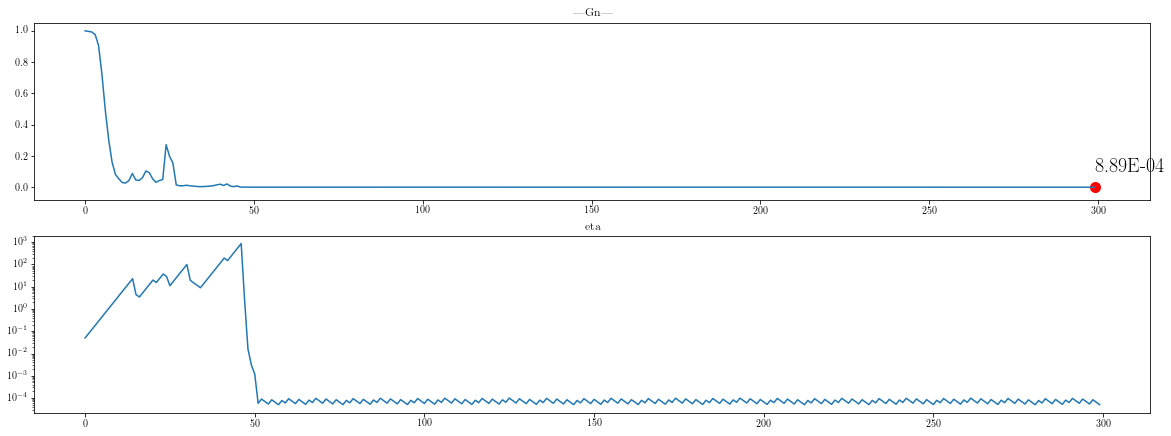

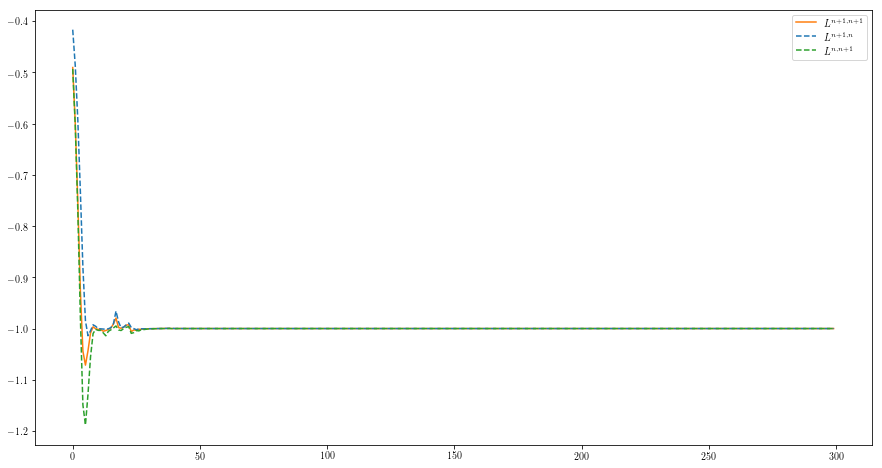

In [97]:
from decimal import Decimal
from matplotlib import rc
#####DEBUG#####
#find minimal Gn, Dn
minG = np.min(Ls[0])
iminG = np.argmin(Ls[0])

fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(4, 1, 1)
ax1.plot(Ls[0])
ax1.scatter(iminG,minG, c = 'r', s = 100)
decG = '%.2E' % Decimal(minG)
ax1.annotate(decG, (iminG,minG+0.1), fontsize=20)
ax1.set_title('|Gn|')
# ax1.axvline(iminD, c = 'black', ls = 'dotted')

ax2 = fig.add_subplot(4, 1, 2)
ax2.semilogy(Ls[1])
# ax4.axvline(iminD, c = 'black', ls = 'dotted')
ax2.set_title('eta');
###############
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.figure(figsize=(15,8))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
iterations = range(len(Ls[0]))
plt.plot(iterations,Ls[2], label=r'$L^{n+1,n+1}$', c='C1')
plt.plot(iterations,Ls[3], label=r'$L^{n+1,n}$', c='C0', linestyle='--')
plt.plot(iterations,Ls[4], label=r'$L^{n,n+1}$',c='C2', linestyle='--')
plt.legend()
# plt.ylim(ymin=-1.00001, ymax=-0.99999)

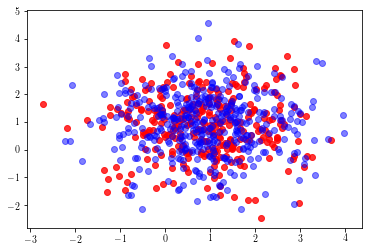

In [98]:
# plt.scatter(x[:,0],x[:,1], color='green',alpha=0.5);
plt.scatter(T[:,0],T[:,1], color='red',alpha=0.8);
plt.scatter(y[:,0],y[:,1], color='blue',alpha=0.5);
# plt.scatter(mu[1][:,0],mu[1][:,1], color='blue', alpha = 0.2);

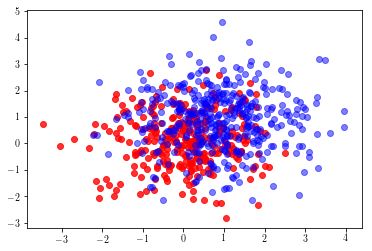

In [84]:
plt.scatter(x[:,0],x[:,1], color='red',alpha=0.8);
plt.scatter(y[:,0],y[:,1], color='blue',alpha=0.5);

## Global algorithm 

In [134]:
#A priori transform between Gaussians(using only mean and variance of the data)
def T(x,y):
    vx = np.cov(x.T)
    vy = np.cov(y.T)
    mx = np.mean(x,axis=0)
    my = np.mean(y,axis=0)

    sqrtx = linalg.sqrtm(vx)
    sqrtx_inv = la.inv(sqrtx)
    ml = np.matmul(sqrtx,vy)
    m = np.matmul(ml,sqrtx)
    M = linalg.sqrtm(m)
    L = np.matmul(sqrtx_inv,M)
    A = np.matmul(L,sqrtx_inv)
    x_T = np.zeros((len(x),2))
    x_T = my+np.einsum('ij,jk->ik',A,(x-mx).T).T

    return x_T
# y_T = T(y,x)
# plt.scatter(x[:,0],x[:,1],color='blue',marker='x')
# plt.scatter(y[:,0],y[:,1],color='red',marker='+')
# plt.scatter(y_T[:,0],y_T[:,1],color='red',marker='x')
def G_interpolate(x,y,K):
    Nx = len(x)
    Ny = len(y)

    d1 = np.random.permutation(Nx)
    d2 = np.random.permutation(Ny)

    x_T = T(x,y)
    y_T = T(y,x)
    mu = []
    mu.append(x)

    for k in range(1,K):
        z0k = (1-k/K)*x[d1[:int(Nx*(1-k/K))],:]+(k/K)*x_T[d1[:int(Nx*(1-k/K))],:]
        zKk = (1-k/K)*y_T[d2[:int(Ny*k/K)],:]+(k/K)*y[d2[:int(Ny*k/K)],:]
        z = np.concatenate([z0k,zKk])
        mu.append(z)
    mu.append(y)

#         #####Visualization of interpolation#######
#     for k in range(K+1):
#         plt.scatter(mu[k][:,0],mu[k][:,1], color='blue', marker='x');
#         plt.draw()
#         plt.show()
#     plt.scatter(y[:,0],y[:,1],color='red',marker='+')
    
    return mu

In [135]:
def idx_choice(x,y):
    Nx = len(x)
    Ny = len(y)
    #assignement for x:
    idxx = np.zeros(Nx)
    q = int(Nx/Ny)
    r = Nx % Ny
    for i in range(q):
        idxx[i*Ny:(i+1)*Ny] = np.random.choice(np.arange(Ny),Ny,replace=False)
    if r!=0: 
        idxx[-r:] = np.random.choice(np.arange(Ny),r,replace=False)
    #assignement for y:
    idxy = np.zeros(Ny)
    q = int(Ny/Nx)
    r = Ny % Nx
    for i in range(q):
        idxy[i*Nx:(i+1)*Nx] = np.random.choice(np.arange(Nx),Nx,replace=False)
    if r!=0: 
        idxy[-r:] = np.random.choice(np.arange(Nx),r,replace=False)
    return(y[idxx.astype(int)],x[idxy.astype(int)])   
def interpolate(x,y,K):
    Nx = len(x)
    Ny = len(y)
    
    x_K, y_0 = idx_choice(x,y)
    mu = []
    mu.append(x)
    for k in range(1,K):
        z0k = (1-k/K)*x+(k/K)*x_K
        rdcx = np.random.choice(np.arange(Nx),int(Nx*(1-k/K)),replace=False)
        zx = z0k[rdcx]
        zKk = (1-k/K)*y_0+(k/K)*y
        rdcy = np.random.choice(np.arange(Ny),int(Ny*k/K),replace=False)
        zy = zKk[rdcy]
        z = np.concatenate([zx,zy])
        mu.append(z)
    mu.append(y)
    
    return mu

In [131]:
def global_ot(x,y,K=30,Maxiter=50,tol=5e-2):
    Nx = len(x)
    Ny = len(y) 
    a_maps = K*[0]
    b_maps = K*[0]


    #Initialize intermediary distributions both from x and y
    x_K = T(x,y)
    mu = interpolate(x,y,K)
    
    
    for niter in range(Maxiter):
        print(niter/Maxiter * 100)#debug
        x_Kold=x_K
        #solve local OT's
        z = x
        for k in range(1,K+1):
            #         #plot before transport
            #         bins = 35
            #         plt.hist(z,density=True, bins=bins, color='red', alpha = 0.5);
            #         plt.hist(mu[k],density=True, bins=bins, color='blue', alpha = 0.5);



            print('Step k = '+str(k))
            plt.scatter(z[:,0],z[:,1], color='red', alpha = 0.5);
            plt.scatter(mu[k][:,0],mu[k][:,1], color='blue', alpha = 0.2);
            plt.title('Before local OT')
            plt.draw()
            plt.show()




            #solve local transport problem
            Tloc,a,b = local_ot(z,mu[k],Niter=200,gamma = 2.5)


            #plot after transport
            #         bins = 35
            #         plt.hist(Tloc,density=True, bins=bins, color='red', alpha = 0.5);
            #         plt.hist(mu[k],density=True, bins=bins, color='blue', alpha = 0.5);
            plt.scatter(Tloc[:,0],Tloc[:,1], color='red', alpha = 0.5);
            plt.scatter(mu[k][:,0],mu[k][:,1], color='blue', alpha = 0.2);
            plt.title('After local OT')
            plt.draw()
            plt.show()

            a_maps[k-1] = a
            b_maps[k-1] = b
            z = Tloc
        x_K = z
        diff = (1/Nx)*la.norm(x_K-x_Kold,2)
        print(diff)
        if diff<tol:
            break
        #update intermediate distributions
        for k in range(1,K):
            mu[k] = (1-k/K)*x+(k/K)*x_K
    return x_K,a_maps,b_maps

0.0
Step k = 1


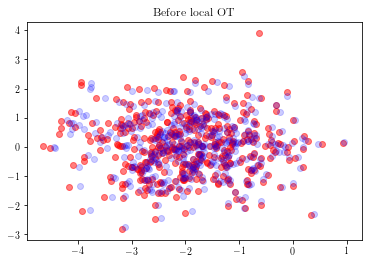

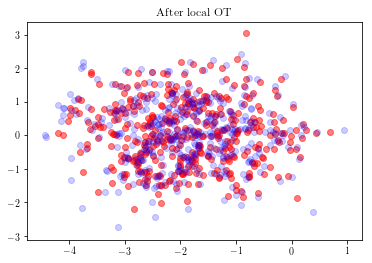

Step k = 2


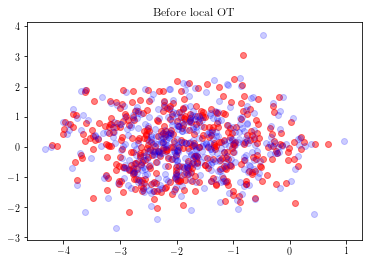

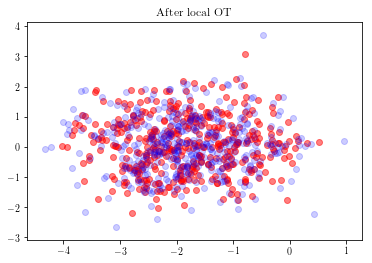

Step k = 3


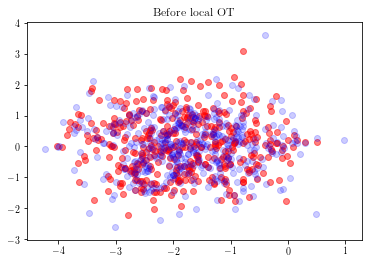

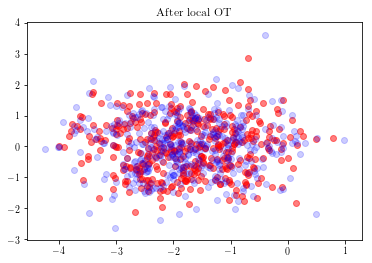

Step k = 4


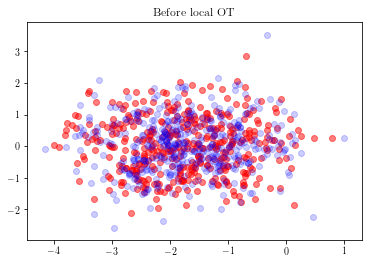

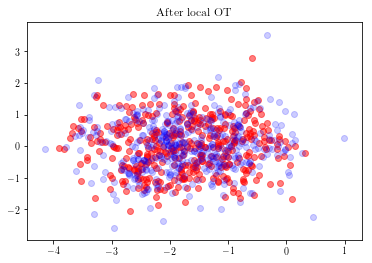

Step k = 5


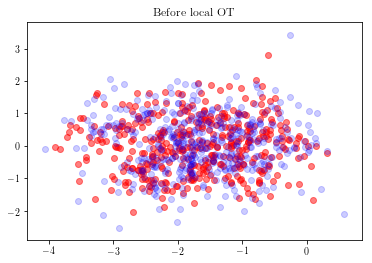

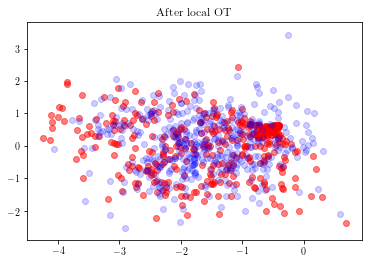

Step k = 6


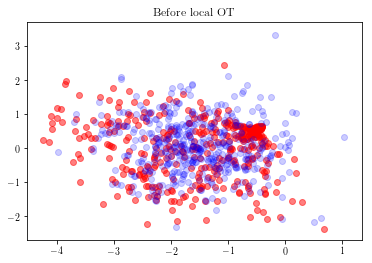

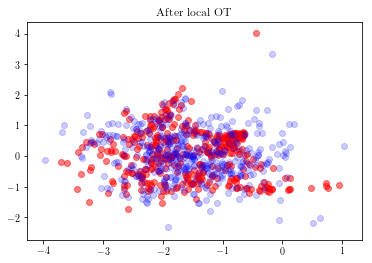

Step k = 7


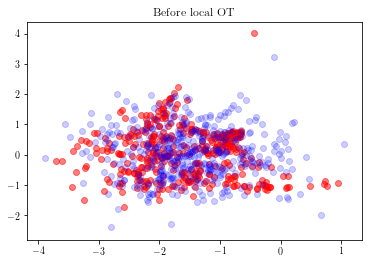

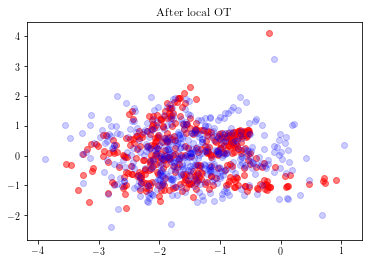

Step k = 8


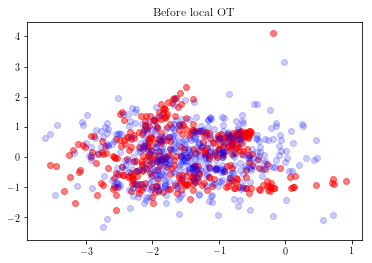

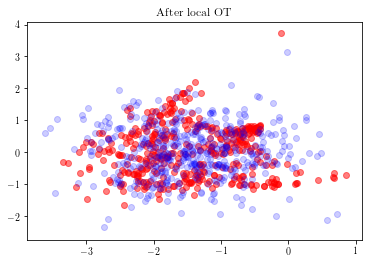

Step k = 9


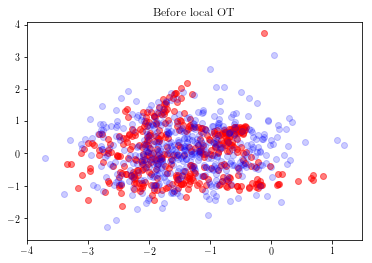

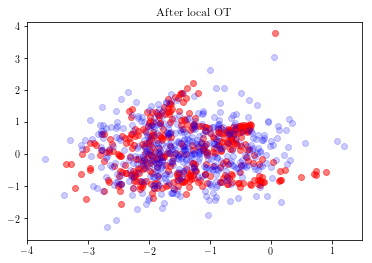

Step k = 10


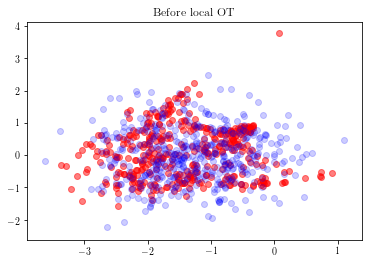

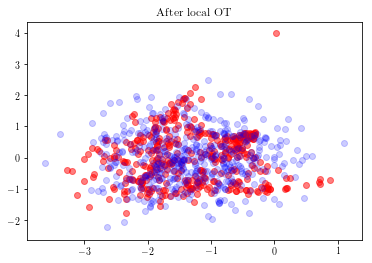

Step k = 11


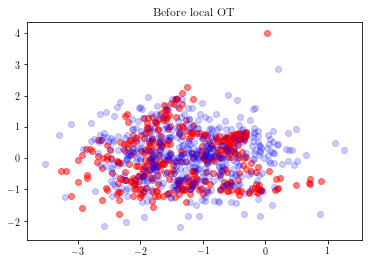

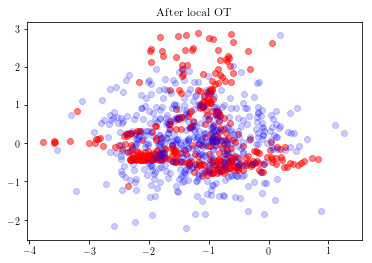

Step k = 12


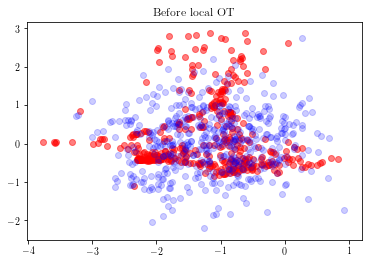

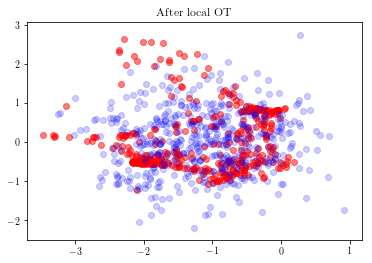

Step k = 13


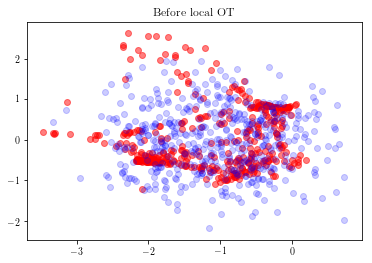

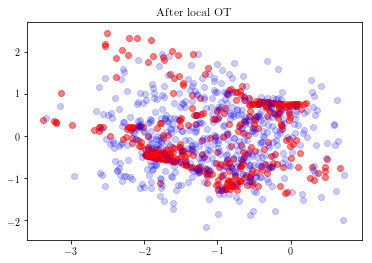

Step k = 14


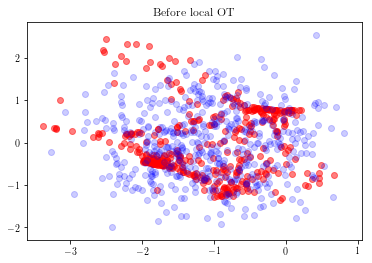

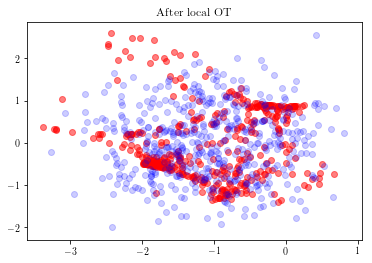

Step k = 15


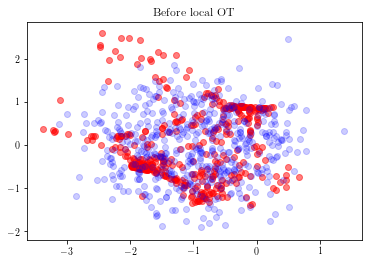

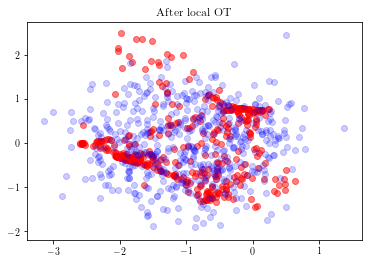

Step k = 16


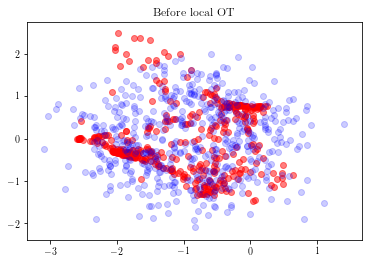

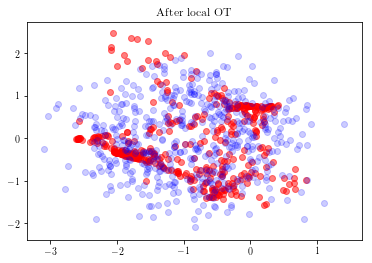

Step k = 17


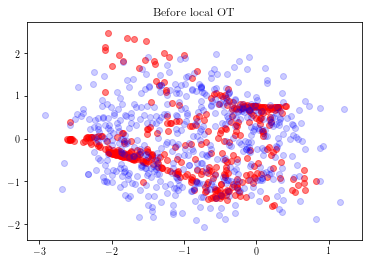

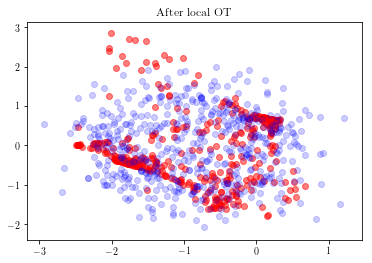

Step k = 18


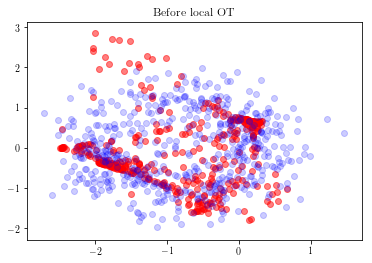

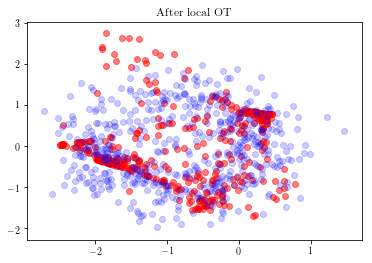

Step k = 19


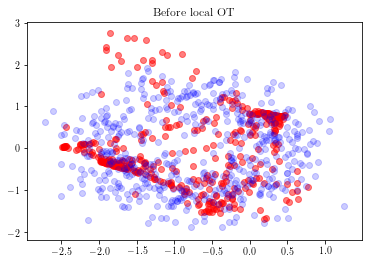

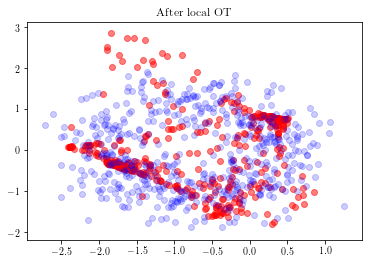

Step k = 20


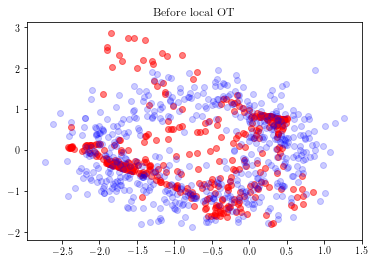

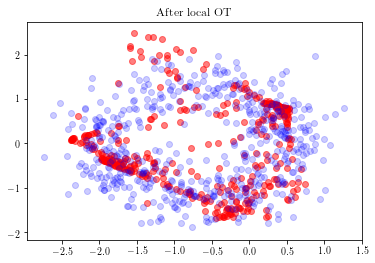

Step k = 21


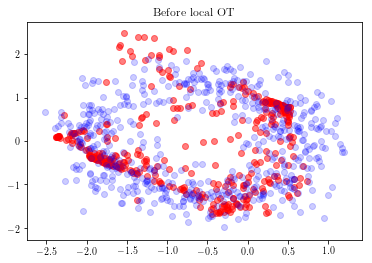

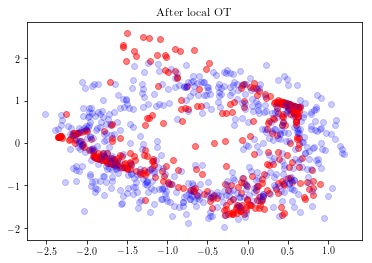

Step k = 22


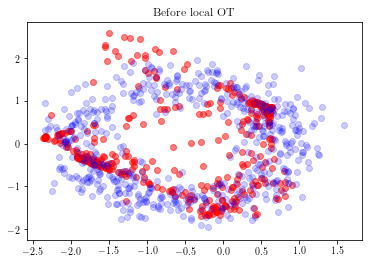

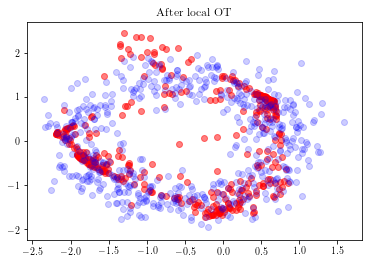

Step k = 23


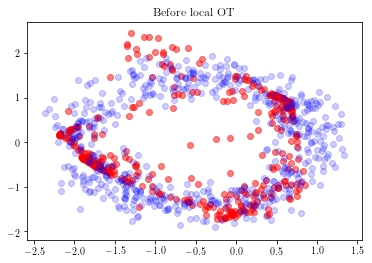

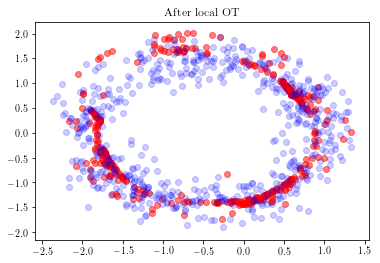

Step k = 24


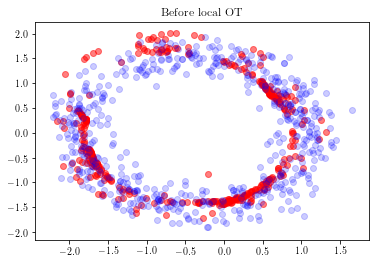

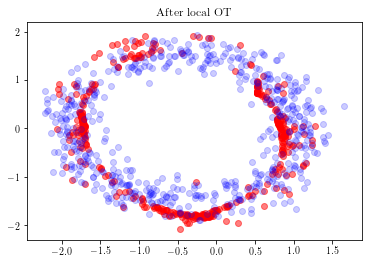

Step k = 25


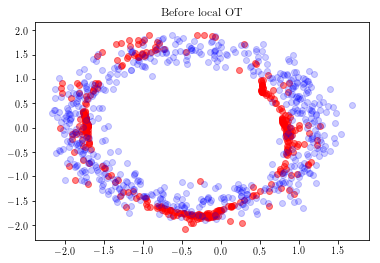

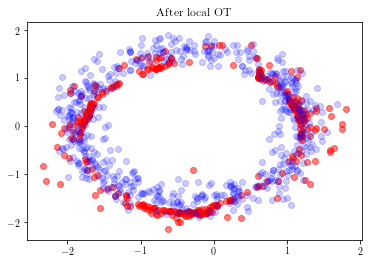

Step k = 26


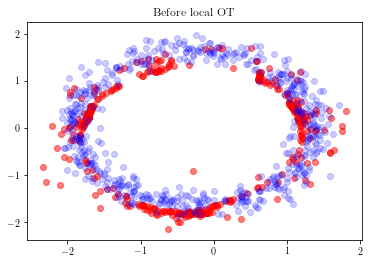

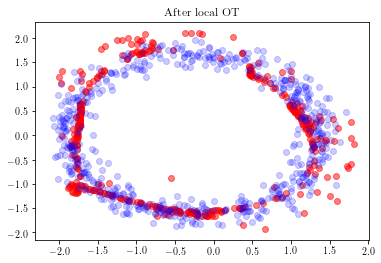

Step k = 27


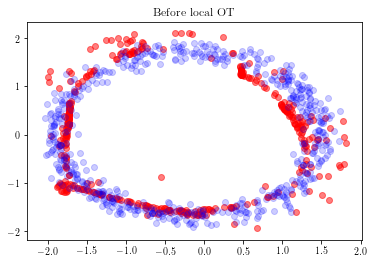

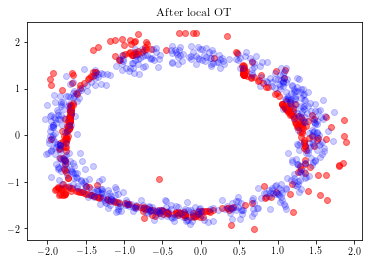

Step k = 28


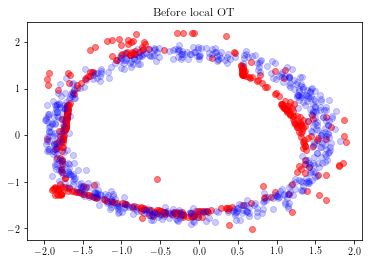

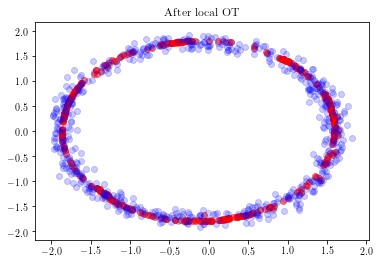

Step k = 29


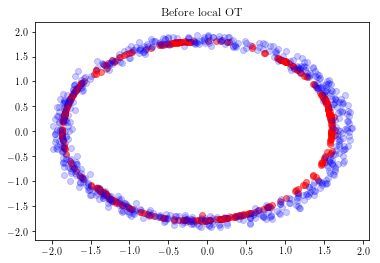

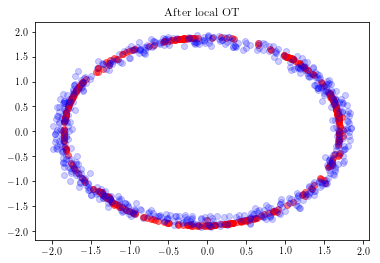

Step k = 30


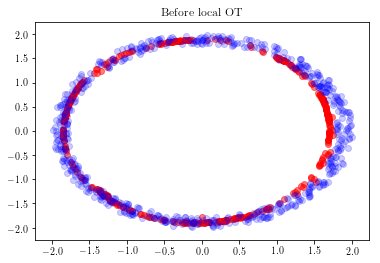

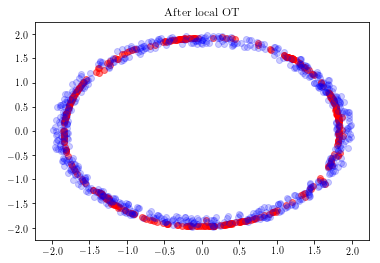

0.1019304509759833
2.0
Step k = 1


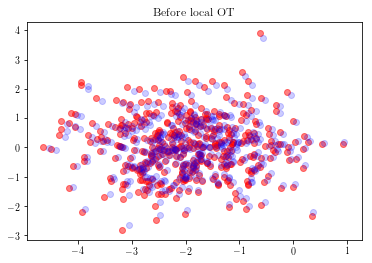

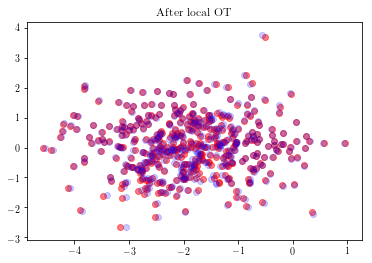

Step k = 2


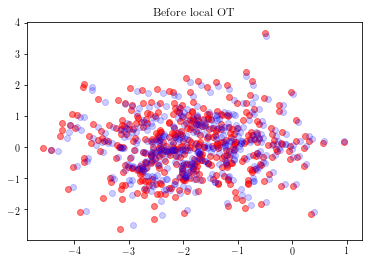

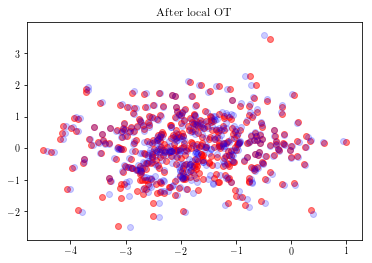

Step k = 3


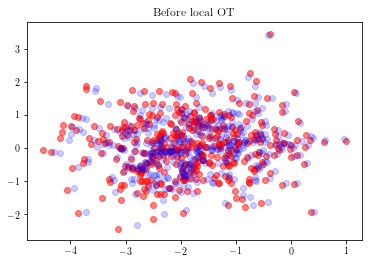

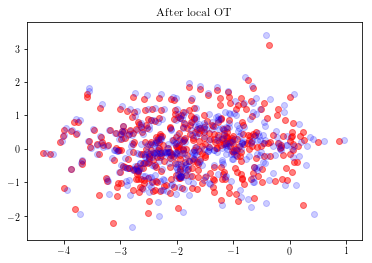

Step k = 4


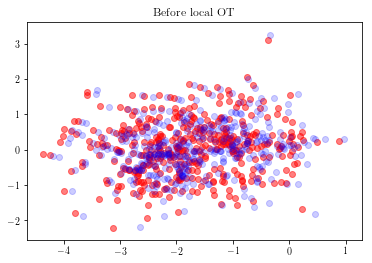

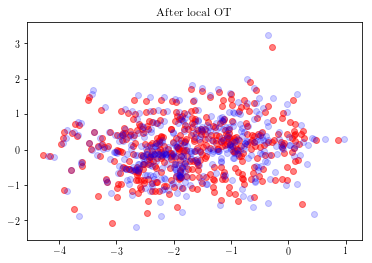

Step k = 5


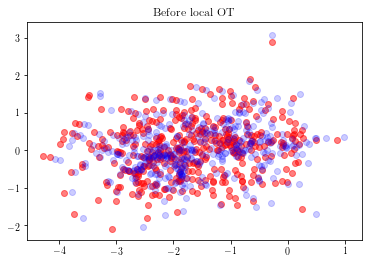

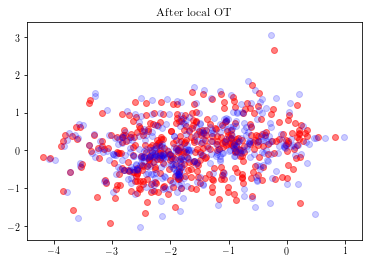

Step k = 6


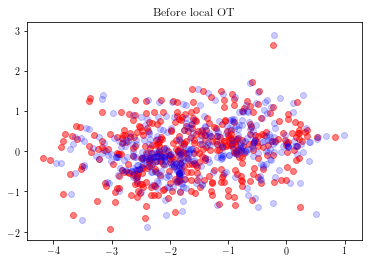

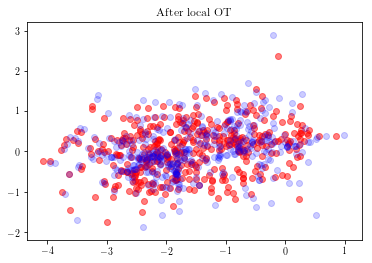

Step k = 7


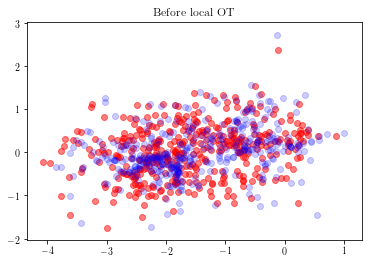

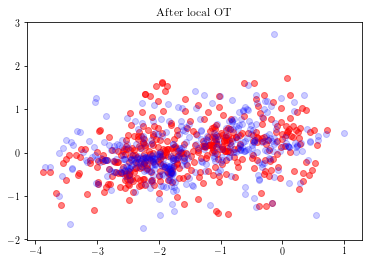

Step k = 8


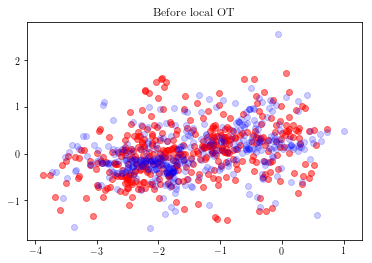

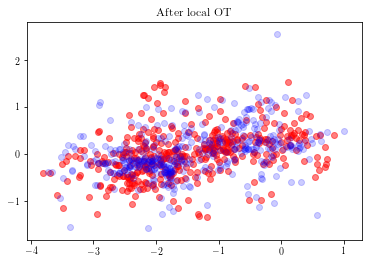

Step k = 9


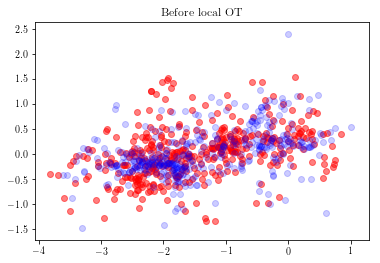

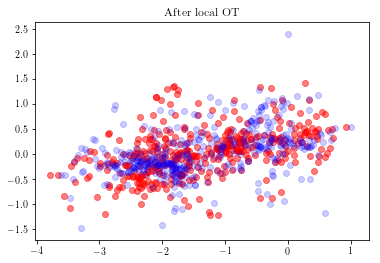

Step k = 10


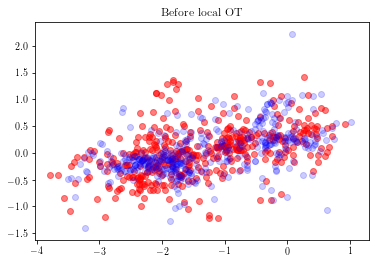

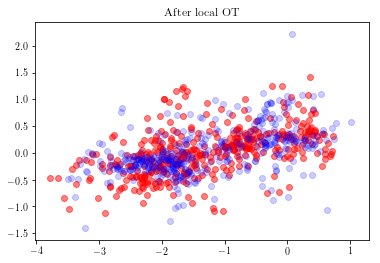

Step k = 11


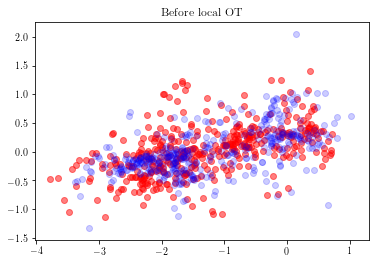

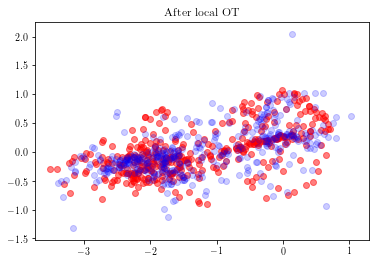

Step k = 12


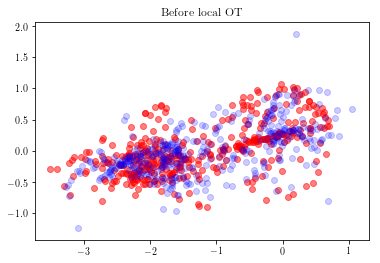

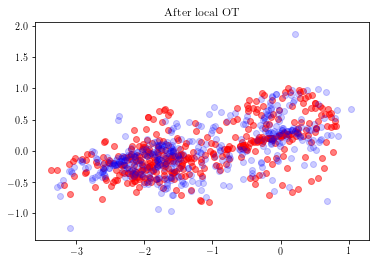

Step k = 13


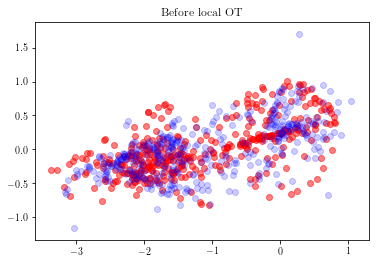

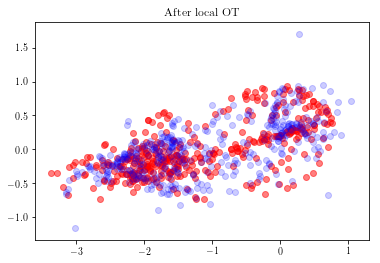

Step k = 14


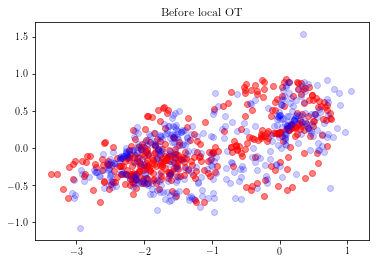

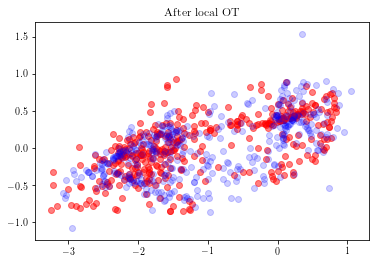

Step k = 15


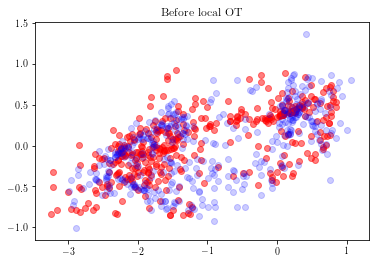

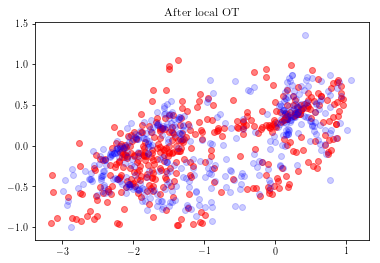

Step k = 16


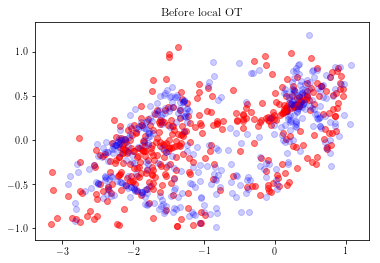

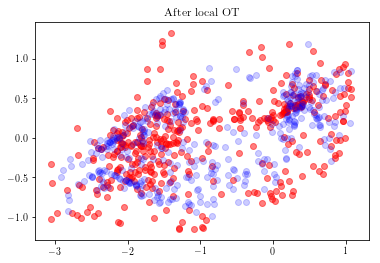

Step k = 17


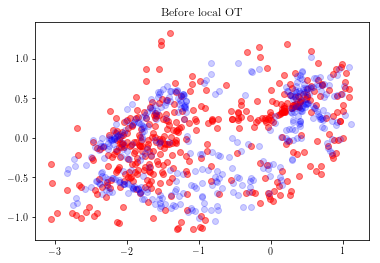

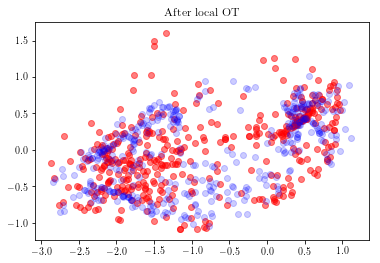

Step k = 18


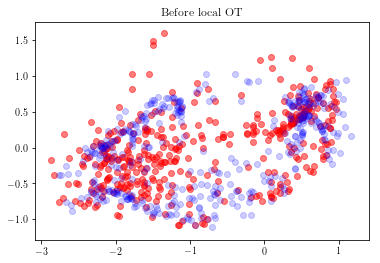

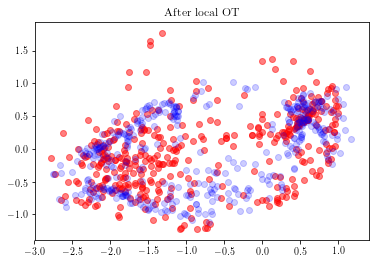

Step k = 19


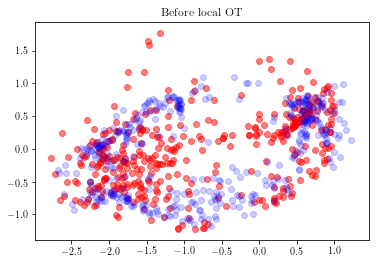

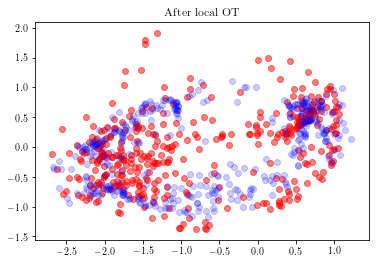

Step k = 20


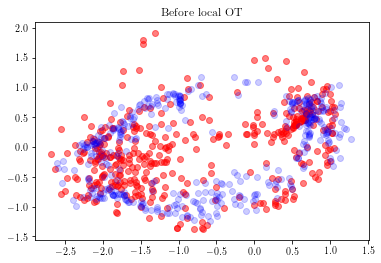

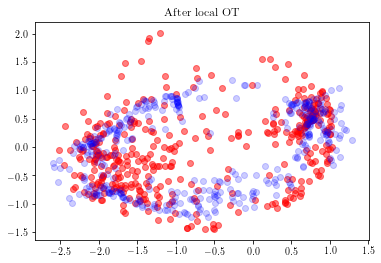

Step k = 21


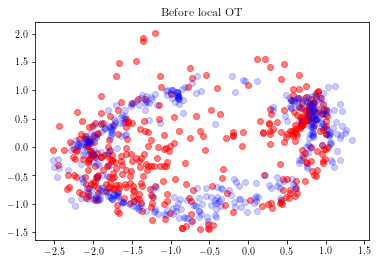

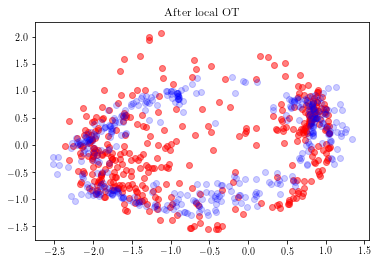

Step k = 22


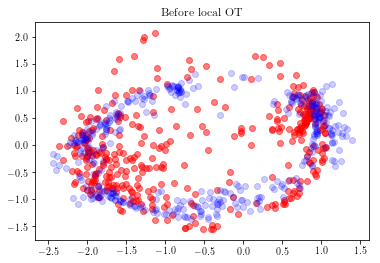

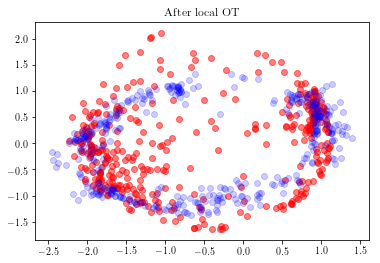

Step k = 23


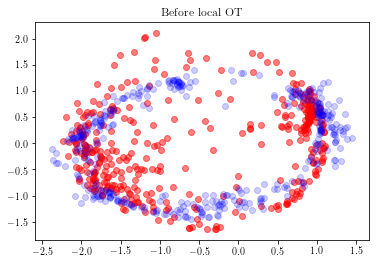

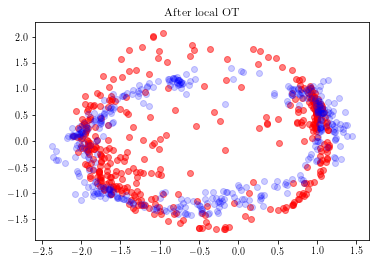

Step k = 24


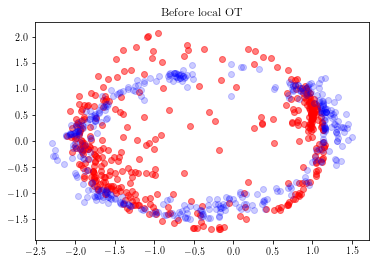

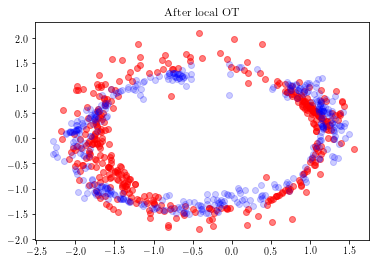

Step k = 25


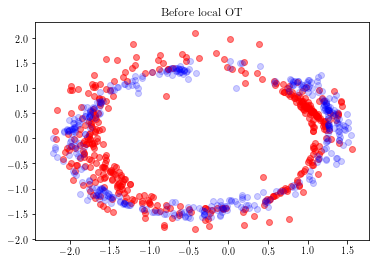

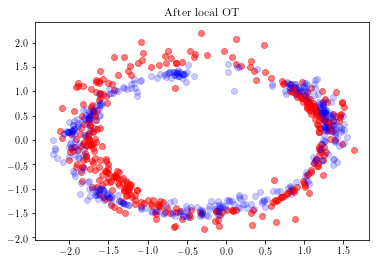

Step k = 26


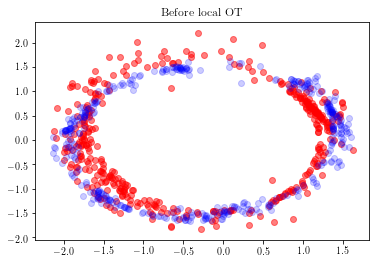

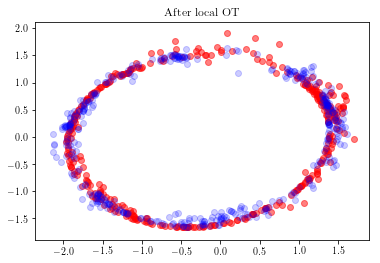

Step k = 27


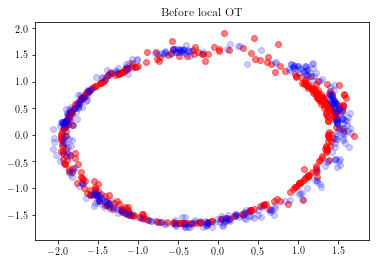

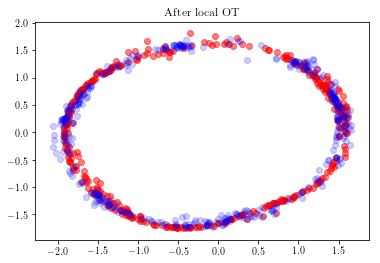

Step k = 28


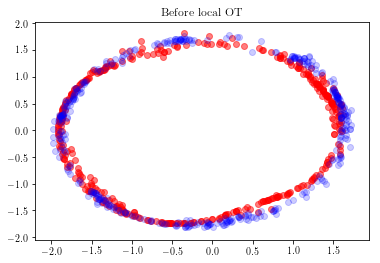

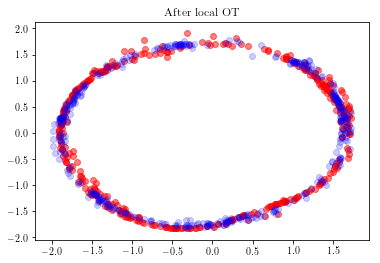

Step k = 29


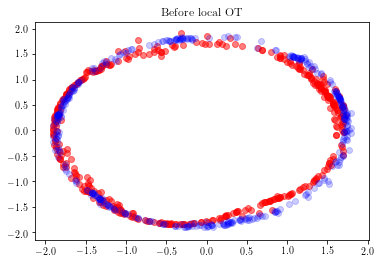

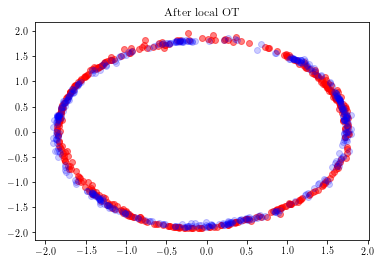

Step k = 30


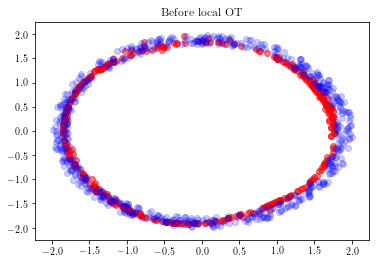

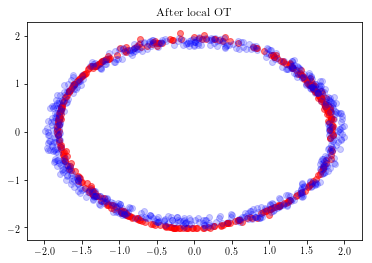

0.07461412079403093


In [138]:
x_K,am,bm = global_ot(x,y,tol=0.1)

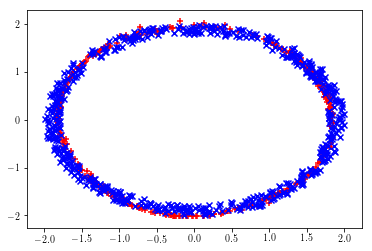

In [139]:
# x_T = Tx(x,y)
# y_T = Ty(y,x)

plt.scatter(x_K[:,0],x_K[:,1], color='red', marker = '+')
plt.scatter(y[:,0],y[:,1], color='blue', marker = 'x')
plt.draw()
plt.show()

In [142]:
print(np.cov(y.T))

[[ 1.8676106  -0.08560709]
 [-0.08560709  1.74224859]]


In [143]:
print(np.mean(y,axis = 0))

[ 0.03831634 -0.01421691]
